# Preparing summary statistics (SumStats) of the GWAS on age-of-onset ischemic stroke for GWAS Catalog

This notebook serves to inspect `AAO GWAS SumStats`, and proceses the _discovery_ meta-analysis GWAS data for sharing through *GWAS Catalog*.

Populations: 
- `gwas_combo` = Combined sexes, European population, `discovery_group/21.04.12.alleur.groupcov.stats.gz`
- `gwas_women` = Women-only data, European population, `discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz`
- `gwas_men` = Men-only, European population, `discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz`


## Check for anomalous alleles

It turns out we have variants that have alleles coded as _DEL_ and as _TT*N_. These two are not resolvable and unacceptable for deposit in repositories or downstream analytical programs. We filtered these through these `baash` commands. 

```
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep "<" | head
esv2668971	1	17676773	0	C	<DEL>	0.651017	0.7855	-0.151376	0.25115	5.5E-01
esv2677880	1	25591101	0	G	<DEL>	0.593077	0.923229	0.0483997	0.226888	8.3E-01
esv2656832	1	25591901	0	G	<DEL>	0.593591	0.922586	0.0500368	0.227043	8.3E-01
esv2657070	1	25614201	0	G	<DEL>	0.611186	0.835544	0.105669	0.241737	6.6E-01
esv2660377	1	26459901	0	C	<DEL>	0.835867	0.997442	0.0309001	0.290807	9.2E-01
esv2657809	1	62115151	0	T	<DEL>	0.853304	0.927741	0.219319	0.313322	4.8E-01
esv2665550	1	108732201	0	C	<DEL>	0.945779	0.656023	0.0765448	0.580506	9.0E-01
esv2676246	1	110223001	0	G	<DEL>	0.283962	0.760732	0.313287	0.273316	2.5E-01
esv2669133	1	112691801	0	G	<DEL>	0.680302	0.911305	-0.149431	0.244641	5.4E-01
esv2674493	1	169225801	0	T	<DEL>	0.623863	0.991748	-0.147698	0.222684	5.1E-01

$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep "N" | head
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs143418322	11	22819068	0	T	TTCN	0.850445	0.981047	-0.391315	0.303895	2.0E-01
rs201380680	11	118373030	0	T	TAN	0.932981	0.876645	0.326323	0.453315	4.7E-01
14-58419899	14	58419899	0	T	TTATN	0.850263	0.94382	-0.31709	0.308973	3.0E-01
rs200456769	18	78014202	0	TTN	T	0.474066	0.9564	0.232862	0.219385	2.9E-01

$ gzcat discovery_group/21.04.12.alleur.groupcov.stats.gz | head -1 > discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz | head -1 > discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | head -1 > discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

$ gzcat discovery_group/21.04.12.alleur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xx.group/21.04.13.xx.eur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzcat discovery_xy.group/21.04.13.xy.eur.groupcov.stats.gz | grep -v "N" | grep -v "<" >> discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

$ gzip -v discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt
$ gzip -v discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt
$ gzip -v discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt

```

## Import necessary libraries

In [186]:
# Function to check for installation of required packages
def check_install_package(package_name):
    try:
        importlib.import_module(package_name)
    except ImportError:
        print(f'{package_name} is not installed. Installing it now...')
        subprocess.check_call(['pip', 'install', package_name])

import os
import glob
import importlib
import subprocess
import sys

# argument parsing
import argparse

# get date and time
from datetime import datetime

# Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
check_install_package('pandas')
import pandas as pd

# pyarrow is supperior to loading parquet files
check_install_package('pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq

# polars is a fast dataframe library
check_install_package('polars')
import polars as pl

# for statistical analysis
check_install_package('scipy')
from scipy import stats
import numpy as np

# scientific colourmaps
# https://www.fabiocrameri.ch/ws/media-library/8c4b111121ff448e843dfef9220bf613/readme_scientificcolourmaps.pdf
check_install_package('cmcrameri')
import cmcrameri as ccm
from cmcrameri import cm

# for plotting
check_install_package('matplotlib')
import matplotlib
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# use Seaborn for visualisations
check_install_package('seaborn')
import seaborn as sns

# for handling GWAS data
import gwaslab as gl

Creating directories for plots

In [187]:
# Create directories for the GWAS data and the reference data
import os
from subprocess import check_output

# general plotting directory
PLOTS_loc = "AAO/PLOTS"

# Reference data directory
REF_loc = "/Users/slaan3/PLINK/references"
print("Checking contents of the reference directory:")
print(check_output(["ls", os.path.join(REF_loc)]).decode("utf8"))

# GWAS data directory
GWAS_RES_loc = "/Users/slaan3/PLINK/_GWAS_Datasets/_SiGN"
print("Checking contents of the GWAS data directory:")
print(check_output(["ls", os.path.join(GWAS_RES_loc)]).decode("utf8"))

# Check if the directory exists
if not os.path.exists(os.path.join(GWAS_RES_loc, "GWASCatalog")):
    # If it doesn't exist, create it
    os.makedirs(os.path.join(GWAS_RES_loc, "GWASCatalog"))

# GWAS Catalog directory
GWASCatalog_loc = os.path.join(GWAS_RES_loc, "GWASCatalog")

Checking contents of the reference directory:
1000G
HRC_r1_1_2016
HRCr11_1000Gp3v5
dbSNP
tcga

Checking contents of the GWAS data directory:
GWASCatalog
discovery_group
discovery_xx.group
discovery_xy.group



## Loading data

Loading the different datasets.

In [188]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# print(check_output(["ls", os.path.join(GWAS_RES_loc, "/meta_discovery/discovery_group/")]).decode("utf8"))

print(check_output(
    ["ls", os.path.join(GWAS_RES_loc, "discovery_group")]).decode("utf8"))
print(check_output(
    ["ls", os.path.join(GWAS_RES_loc, "discovery_xx.group")]).decode("utf8"))
print(check_output(
    ["ls", os.path.join(GWAS_RES_loc, "discovery_xy.group")]).decode("utf8"))

21.04.12.alleur.groupcov.stats.gz
21.04.12.alleur.groupcov.stats.noDEL_TTN.txt.gz

21.04.13.xx.eur.groupcov.stats.gz
21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt.gz

21.04.13.xy.eur.groupcov.stats.gz
21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt.gz



### Combined data

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.850249	0.301118	-0.658801	0.423637	1.2E-01
rs180734498	1	13302	0	C	T	0.906641	0.332755	-0.139703	0.509556	7.8E-01
rs140337953	1	30923	0	G	T	0.165905	0.330267	0.317905	0.40355	4.3E-01
rs116400033	1	51479	0	T	A	0.819279	0.318227	-0.199339	0.383897	6.0E-01
```


In [189]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc, "discovery_group/21.04.12.alleur.groupcov.stats.noDEL_TTN.txt.gz"
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_combo = temp.to_pandas()

### Women-only

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.848383	0.301118	-0.824988	0.659326	2.1E-01
rs180734498	1	13302	0	C	T	0.907042	0.332755	-0.659718	0.806601	4.1E-01
rs140337953	1	30923	0	G	T	0.166339	0.330267	0.782017	0.644221	2.2E-01
rs116400033	1	51479	0	T	A	0.816609	0.318227	-0.173976	0.602009	7.7E-01
```


In [190]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc,
        "discovery_xx.group/21.04.13.xx.eur.groupcov.stats.noDEL_TTN.txt.gz",
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_women = temp.to_pandas()

### Men-only

The general format of the data is as follows:

```
SNP	CHR	BP	GENPOS	ALLELE1	ALLELE0	A1FREQ	INFO	BETA	SE	P_BOLT_LMM_INF
rs58108140	1	10583	0	G	A	0.851716	0.301118	-0.519809	0.549089	3.4E-01
rs180734498	1	13302	0	C	T	0.906325	0.332755	0.271376	0.651686	6.8E-01
rs140337953	1	30923	0	G	T	0.165563	0.330267	-0.0024671	0.513017	1.0E+00
rs116400033	1	51479	0	T	A	0.821378	0.318227	-0.265338	0.494794	5.9E-01
```


In [191]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import polars as pl

temp = pl.read_csv(
    source=os.path.join(
        GWAS_RES_loc,
        "discovery_xy.group/21.04.13.xy.eur.groupcov.stats.noDEL_TTN.txt.gz",
    ),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    # n_rows=1000, # for debugging
    quote_char=None,
    # necessary to fix issues with missing values when reading data
    null_values=["NA"],
)
# change polars dataframe to pandas dataframe
gwas_men = temp.to_pandas()

### Inspection of data

Here we do a quick check on what is what in the data.

Let's inspect what is what.

Printing head of combined data:

In [192]:
gwas_combo.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.850249,0.301118,-0.658801,0.423637,0.12
1,rs180734498,1,13302,0,C,T,0.906641,0.332755,-0.139703,0.509556,0.78
2,rs140337953,1,30923,0,G,T,0.165905,0.330267,0.317905,0.403550,0.43
3,rs116400033,1,51479,0,T,A,0.819279,0.318227,-0.199339,0.383897,0.60
4,rs141149254,1,54490,0,G,A,0.823351,0.322577,-0.035508,0.383277,0.93


Printing head of Women-only data:

In [193]:
gwas_women.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.848383,0.301118,-0.824988,0.659326,0.21
1,rs180734498,1,13302,0,C,T,0.907042,0.332755,-0.659718,0.806601,0.41
2,rs140337953,1,30923,0,G,T,0.166339,0.330267,0.782017,0.644221,0.22
3,rs116400033,1,51479,0,T,A,0.816609,0.318227,-0.173976,0.602009,0.77
4,rs141149254,1,54490,0,G,A,0.820977,0.322577,0.308928,0.603387,0.61


Printing head of Men-only data

In [194]:
gwas_men.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF
0,rs58108140,1,10583,0,G,A,0.851716,0.301118,-0.519809,0.549089,0.34
1,rs180734498,1,13302,0,C,T,0.906325,0.332755,0.271376,0.651686,0.68
2,rs140337953,1,30923,0,G,T,0.165563,0.330267,-0.002467,0.513017,1.00
3,rs116400033,1,51479,0,T,A,0.821378,0.318227,-0.265338,0.494794,0.59
4,rs141149254,1,54490,0,G,A,0.825216,0.322577,-0.371793,0.492553,0.45


In [195]:
print("Printing shape of combined data:\n", gwas_combo.shape)

Printing shape of combined data:
 (6750263, 11)


In [196]:
print("Printing shape of Women-only data:\n", gwas_women.shape)

Printing shape of Women-only data:
 (6750263, 11)


In [197]:
print("Printing shape of Men-only data:\n", gwas_men.shape)

Printing shape of Men-only data:
 (6750263, 11)


In [198]:
print("Printing columns of combined data:\n", gwas_combo.columns)

Printing columns of combined data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [199]:
print("Printing columns of Women-only data:\n", gwas_women.columns)

Printing columns of Women-only data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [200]:
print("Printing columns of Men-only data:\n", gwas_men.columns)

Printing columns of Men-only data:
 Index(['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'INFO',
       'BETA', 'SE', 'P_BOLT_LMM_INF'],
      dtype='object')


In [201]:
print("Printing info of combined data:\n", gwas_combo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of combined data:
 None


In [202]:
print("Printing info of Women-only data:\n", gwas_women.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of Women-only data:
 None


In [203]:
print("Printing info of Men-only data:\n", gwas_men.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750263 entries, 0 to 6750262
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SNP             object 
 1   CHR             int64  
 2   BP              int64  
 3   GENPOS          int64  
 4   ALLELE1         object 
 5   ALLELE0         object 
 6   A1FREQ          float64
 7   INFO            float64
 8   BETA            float64
 9   SE              float64
 10  P_BOLT_LMM_INF  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 566.5+ MB
Printing info of Men-only data:
 None


Getting some per column summary statistics.

In [204]:
print("Printing describe of combined data:\n", gwas_combo.describe())

Printing describe of combined data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689734e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494505e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.794340e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.018640e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.439010e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.811840e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.990260e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -6.483778e-04  2.369407e-01    4.940284e-01  
std    2.532999e-01  7.800336e-02    2.908264e-01  
min   -4.723600e+00  1.639520e-01    7.000000e-07  
25%   -1.536275e-0

In [205]:
print("Printing describe of Women-only data:\n", gwas_women.describe())

Printing describe of Women-only data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689662e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494700e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.161070e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.019460e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.438440e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.812000e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.991110e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -1.582467e-04  3.738470e-01    4.935410e-01  
std    3.988856e-01  1.233700e-01    2.891631e-01  
min   -8.927970e+00  2.563900e-01    9.300000e-07  
25%   -2.427890e

In [206]:
print("Printing describe of Men-only data:\n", gwas_men.describe())

Printing describe of Men-only data:
                 CHR            BP     GENPOS        A1FREQ          INFO  \
count  6.750263e+06  6.750263e+06  6750263.0  6.750263e+06  6.750263e+06   
mean   8.697022e+00  7.832229e+07        0.0  6.689790e-01  9.668220e-01   
std    5.774145e+00  5.663508e+07        0.0  2.494584e-01  7.043201e-02   
min    1.000000e+00  3.020000e+02        0.0  1.832750e-03  2.183440e-02   
25%    4.000000e+00  3.168946e+07        0.0  5.018340e-01  9.728170e-01   
50%    8.000000e+00  6.859110e+07        0.0  7.438510e-01  9.918490e-01   
75%    1.300000e+01  1.142337e+08        0.0  8.811620e-01  9.971240e-01   
max    2.200000e+01  2.492328e+08        0.0  9.992090e-01  1.000000e+00   

               BETA            SE  P_BOLT_LMM_INF  
count  6.750263e+06  6.750263e+06    6.750263e+06  
mean  -1.550811e-03  3.037693e-01    4.966501e-01  
std    3.225175e-01  1.000948e-01    2.896907e-01  
min   -5.716510e+00  2.083970e-01    3.700000e-08  
25%   -1.957720e-0

### Basic visualisations

Here we plot histograms of allele frequencies, effect, and sample size .

#### Sampling from the data
Here we provide an example on how to take a sample of n=800,000 rows, representing ±10% of the data, for easy plotting. This should be representative for most things we are interested in.

In [207]:
# example code to get a sample
# gwas_combo_sample = gwas_combo.sample(800000)

# gwas_women_sample = gwas_women.sample(800000)

# gwas_men_sample = gwas_men.sample(800000)

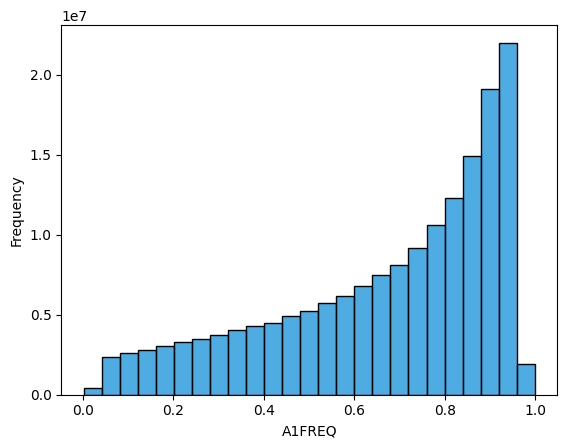

In [208]:
import seaborn as sns

sns.histplot(
    data=gwas_combo,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.COMBINED.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.COMBINED.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

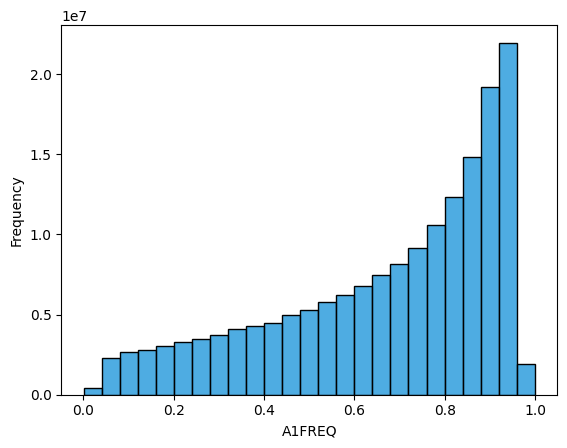

In [209]:
import seaborn as sns

sns.histplot(
    data=gwas_women,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.WOMEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.WOMEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

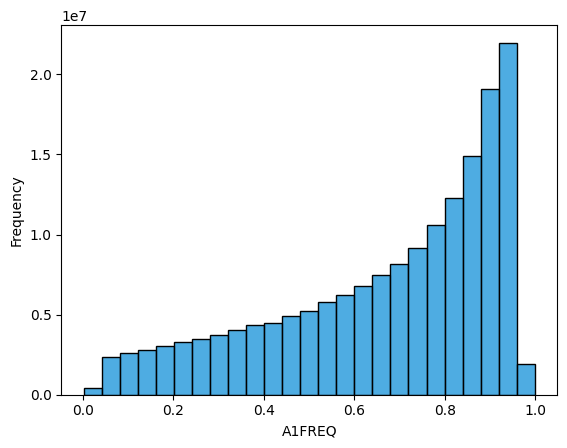

In [210]:
import seaborn as sns

sns.histplot(
    data=gwas_men,  # gwas_combo_sample,
    x="A1FREQ",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.MEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF.MEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

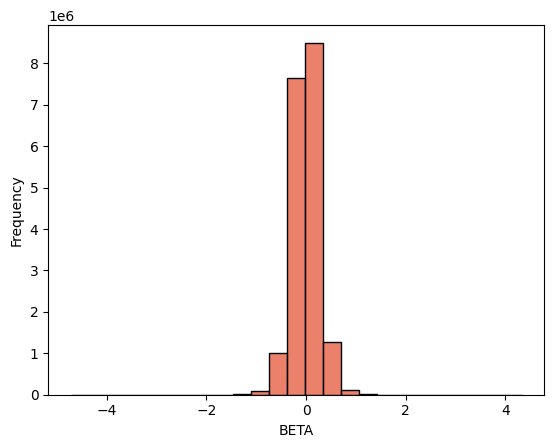

In [211]:
sns.histplot(
    data=gwas_combo,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.COMBINED.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.COMBINED.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

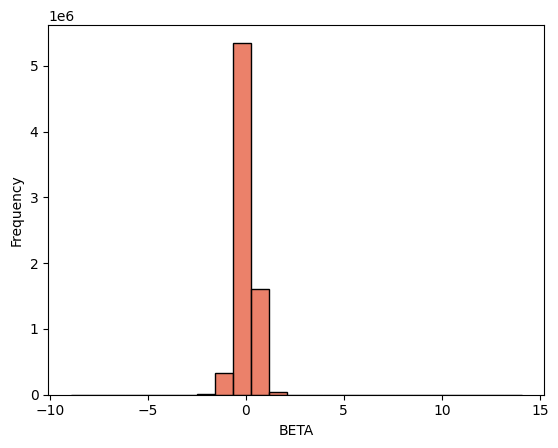

In [212]:
sns.histplot(
    data=gwas_women,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.WOMEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.WOMEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

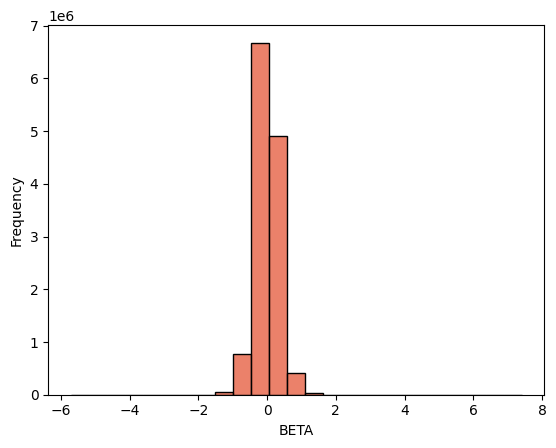

In [213]:
sns.histplot(
    data=gwas_men,  # gwas_combo_sample,
    x="BETA",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.MEN.png"),
    dpi=300,
    bbox_inches="tight",
    format="png",
)
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect.MEN.pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

### SumStats quality control

Here we first check and fix headers, and contents of the SumStats object.

First, we load the data and inspect it using `GWASLab`. Note that for this to work, some column types need to be adjusted..

In [214]:
gwas_combo[["CHR"]] = gwas_combo[["CHR"]].astype("Int64")

gwas_women[["CHR"]] = gwas_women[["CHR"]].astype("Int64")

gwas_men[["CHR"]] = gwas_men[["CHR"]].astype("Int64")

In [215]:
gwas_combo[["BP"]] = gwas_combo[["BP"]].astype("Int64")

gwas_women[["BP"]] = gwas_women[["BP"]].astype("Int64")

gwas_men[["BP"]] = gwas_men[["BP"]].astype("Int64")

In [216]:
# create new SNPID column based on chromosome, position, and alleles
# down the road we need an SNPID column to merge with the reference data and which does not contain 'ID' because this is not correctly interpreted by GWASLab

gwas_combo["CHRBPID"] = gwas_combo["CHR"].astype(
    str) + ":" + gwas_combo["BP"].astype(str)
# from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/group
gwas_combo["N"] = 12145

In [217]:
gwas_women["CHRBPID"] = gwas_women["CHR"].astype(
    str) + ":" + gwas_women["BP"].astype(str)
# from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/xx.group
gwas_women["N"] = 5344

In [218]:
gwas_men["CHRBPID"] = gwas_men["CHR"].astype(
    str) + ":" + gwas_men["BP"].astype(str)
gwas_men["N"] = 6801  # from an *.out file at /hpc/dhl_ec/svanderlaan/projects/sign/vonberg_joanna/2.Age.of.onset/linreg_aoo_unrestricted_bolt/eur.everything.butwhi/xy.group

In [219]:
gwas_combo.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.850249,0.301118,-0.658801,0.423637,0.12,1:10583,12145
1,rs180734498,1,13302,0,C,T,0.906641,0.332755,-0.139703,0.509556,0.78,1:13302,12145
2,rs140337953,1,30923,0,G,T,0.165905,0.330267,0.317905,0.403550,0.43,1:30923,12145
3,rs116400033,1,51479,0,T,A,0.819279,0.318227,-0.199339,0.383897,0.60,1:51479,12145
4,rs141149254,1,54490,0,G,A,0.823351,0.322577,-0.035508,0.383277,0.93,1:54490,12145


In [220]:
gwas_women.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.848383,0.301118,-0.824988,0.659326,0.21,1:10583,5344
1,rs180734498,1,13302,0,C,T,0.907042,0.332755,-0.659718,0.806601,0.41,1:13302,5344
2,rs140337953,1,30923,0,G,T,0.166339,0.330267,0.782017,0.644221,0.22,1:30923,5344
3,rs116400033,1,51479,0,T,A,0.816609,0.318227,-0.173976,0.602009,0.77,1:51479,5344
4,rs141149254,1,54490,0,G,A,0.820977,0.322577,0.308928,0.603387,0.61,1:54490,5344


In [221]:
gwas_men.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,BETA,SE,P_BOLT_LMM_INF,CHRBPID,N
0,rs58108140,1,10583,0,G,A,0.851716,0.301118,-0.519809,0.549089,0.34,1:10583,6801
1,rs180734498,1,13302,0,C,T,0.906325,0.332755,0.271376,0.651686,0.68,1:13302,6801
2,rs140337953,1,30923,0,G,T,0.165563,0.330267,-0.002467,0.513017,1.00,1:30923,6801
3,rs116400033,1,51479,0,T,A,0.821378,0.318227,-0.265338,0.494794,0.59,1:51479,6801
4,rs141149254,1,54490,0,G,A,0.825216,0.322577,-0.371793,0.492553,0.45,1:54490,6801


In [222]:
gwas_combo.rename(columns={"SNP": "VariantID"}, inplace=True)
gwas_women.rename(columns={"SNP": "VariantID"}, inplace=True)
gwas_men.rename(columns={"SNP": "VariantID"}, inplace=True)

In [223]:
import gwaslab as gl

# Specify the columns:
gwas_combo_sumstats = gl.Sumstats(
    gwas_combo,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Fri Sep 15 17:13:12 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:12 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:12 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:17 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:17 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:17 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:19 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:13:22 2023 Start to reorder the columns...
Fri Sep 15 17:13:22 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:13:22 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:13:22 2023 Finished sorting columns successfully!
Fri Sep 15 17:13:22 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [224]:
import gwaslab as gl

# Specify the columns:
gwas_women_sumstats = gl.Sumstats(
    gwas_women,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Fri Sep 15 17:13:32 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:32 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:32 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:38 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:38 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:38 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:41 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:13:44 2023 Start to reorder the columns...
Fri Sep 15 17:13:44 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:13:44 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:13:44 2023 Finished sorting columns successfully!
Fri Sep 15 17:13:45 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [225]:
import gwaslab as gl

# Specify the columns:
gwas_men_sumstats = gl.Sumstats(
    gwas_men,
    snpid="CHRBPID",
    # rsid="SNPID", # not available
    chrom="CHR",
    pos="BP",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    beta="BETA",
    se="SE",
    p="P_BOLT_LMM_INF",
    # direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=["VariantID", "INFO"],
    build="19",
    verbose=True,
)

Fri Sep 15 17:13:45 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:45 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:45 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:50 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:50 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:50 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:52 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:29:12 2023 Start to reorder the columns...
Fri Sep 15 17:29:12 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:29:12 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:29:13 2023 Finished sorting columns successfully!
Fri Sep 15 17:29:13 2023  -Column: SNPID  CHR    POS   EA       NEA      EAF     BET

In [226]:
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.850249,-0.658801,0.423637,0.12,0.301118,12145,1999999,rs58108140
1,1:13302,1,13302,C,T,0.906641,-0.139703,0.509556,0.78,0.332755,12145,1999999,rs180734498
2,1:30923,1,30923,G,T,0.165905,0.317905,0.403550,0.43,0.330267,12145,1999999,rs140337953
3,1:51479,1,51479,T,A,0.819279,-0.199339,0.383897,0.60,0.318227,12145,1999999,rs116400033
4,1:54490,1,54490,G,A,0.823351,-0.035508,0.383277,0.93,0.322577,12145,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.853726,-0.027140,0.294785,0.93,0.641013,12145,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.664004,0.239342,0.212296,0.26,0.695615,12145,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.723106,0.277995,0.224458,0.22,0.696999,12145,1999999,rs3896457


In [227]:
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.848383,-0.824988,0.659326,0.21,0.301118,5344,1999999,rs58108140
1,1:13302,1,13302,C,T,0.907042,-0.659718,0.806601,0.41,0.332755,5344,1999999,rs180734498
2,1:30923,1,30923,G,T,0.166339,0.782017,0.644221,0.22,0.330267,5344,1999999,rs140337953
3,1:51479,1,51479,T,A,0.816609,-0.173976,0.602009,0.77,0.318227,5344,1999999,rs116400033
4,1:54490,1,54490,G,A,0.820977,0.308928,0.603387,0.61,0.322577,5344,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.851828,0.390056,0.459037,0.40,0.641013,5344,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.660294,0.058844,0.336962,0.86,0.695615,5344,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.721628,0.374821,0.356019,0.29,0.696999,5344,1999999,rs3896457


In [228]:
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.851716,-0.519809,0.549089,0.34,0.301118,6801,1999999,rs58108140
1,1:13302,1,13302,C,T,0.906325,0.271376,0.651686,0.68,0.332755,6801,1999999,rs180734498
2,1:30923,1,30923,G,T,0.165563,-0.002467,0.513017,1.00,0.330267,6801,1999999,rs140337953
3,1:51479,1,51479,T,A,0.821378,-0.265338,0.494794,0.59,0.318227,6801,1999999,rs116400033
4,1:54490,1,54490,G,A,0.825216,-0.371793,0.492553,0.45,0.322577,6801,1999999,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.855217,-0.274366,0.381691,0.47,0.641013,6801,1999999,rs144549712
6750259,22:51233300,22,51233300,C,T,0.666920,0.398509,0.270816,0.14,0.695615,6801,1999999,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1999999,rs200507571
6750261,22:51237063,22,51237063,T,C,0.724267,0.245600,0.286446,0.39,0.696999,6801,1999999,rs3896457


In [229]:
gwas_combo_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 17:29:15 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6544740   
         Low_frequency                                                 202899   
         Rare                                                            2624   
P        Minimum                                                        7e-07   
         Significant                                                        0   
         Suggestive                                                        28   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.96  
         Low_frequency            3.01  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [230]:
gwas_women_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 17:39:43 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6540936   
         Low_frequency                                                 206646   
         Rare                                                            2681   
P        Minimum                                                      9.3e-07   
         Significant                                                        0   
         Suggestive                                                        21   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.90  
         Low_frequency            3.06  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [231]:
gwas_men_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750263   
         Column_num                                                        13   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 17:39:49 2023   
MISSING  Missing_total                                                      0   
MAF      Common                                                       6543452   
         Low_frequency                                                 204173   
         Rare                                                            2637   
P        Minimum                                                      3.7e-08   
         Significant                                                        2   
         Suggestive                                                        12   
STATUS   1999999                                                      6750263   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total            0.00  
MAF      Common                  96.94  
         Low_frequency            3.02  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1999999                100.00

In [232]:
gwas_combo_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


In [233]:
gwas_women_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


In [234]:
gwas_men_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,6750263,100.0


#### Intermediate cleaning

Here we cleanup the originally loaded data, to clear memory.

In [235]:
del gwas_combo
del gwas_women
del gwas_men

#### Get reference data

We align the data to the reference genome, this will work for most common variants. Before that, we check which reference datasets are available, and get these.

In [236]:
# check references
gl.check_available_ref()

# {'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
#  '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
#  '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
#  '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eur_hg38_md5': '228d3285fa99132cc6321e2925e0768d',
#  '1kg_eur_hg38_tbi': 'https://www.dropbox.com/s/ze8g58x75x9qbf0/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_sas_hg19': 'https://www.dropbox.com/scl/fi/fubqvuj3p4ii4y35zknv8/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=5z50f66iltjchcaszznq5bczt&dl=1',
#  '1kg_sas_hg19_md5': 'e2d3f9e2e6580d05e877e9effd435c4e',
#  '1kg_sas_hg19_tbi': 'https://www.dropbox.com/scl/fi/icnmrnzee7ofdpx5l96tg/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=st8t88snby26q37rqi6zh5zck&dl=1',
#  '1kg_amr_hg19': 'https://www.dropbox.com/scl/fi/bxa4zfngsxsc38rhtiv8c/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=ibcn8hb1n8n36j3u0jfzci267&dl=1',
#  '1kg_amr_hg19_md5': '68d3cdf01cbabdae6e74a07795fa881c',
#  '1kg_amr_hg19_tbi': 'https://www.dropbox.com/scl/fi/1zk16x7h4r89jurzwu05u/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=b4cere4w38zvzyfitfge3r8n0&dl=1',
#  '1kg_sas_hg38': 'https://www.dropbox.com/scl/fi/jr3l5zz42py3kny2bccmj/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=x0t6tsy71jxzf021wfqdn8k5q&dl=1',
#  '1kg_sas_hg38_md5': 'e5d79bea1958aa50c23f618d342ccc83',
#  '1kg_sas_hg38_tbi': 'https://www.dropbox.com/scl/fi/02oia4ur5r7w9qgiuf6i9/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=00p9rxe0xzfs6hr1rg4d8oadm&dl=1',
#  '1kg_amr_hg38': 'https://www.dropbox.com/scl/fi/4t4tyuhzp78uyb6tgkroq/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=p96gbs1tcdia31jnjv1b82kuz&dl=1',
#  '1kg_amr_hg38_md5': '229fbd610001cf6f137b7f738352a44a',
#  '1kg_amr_hg38_tbi': 'https://www.dropbox.com/scl/fi/x0dby543tr9xpaqj2i0ba/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=uj8o7j0cy0spipe174jn54sqs&dl=1',
#  '1kg_afr_hg19': 'https://www.dropbox.com/scl/fi/tq4w9lyt5z47ym7grtrxg/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=k3bimeu3yr5loq8hohba5mr6k&dl=1',
#  '1kg_afr_hg19_md5': 'f7b4425f39e8292dce6f13711e7f6c50',
#  '1kg_afr_hg19_tbi': 'https://www.dropbox.com/scl/fi/0giiptu0btwj1kfm6jdzr/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=ucb5weprsc5prcg8hvtgmruxx&dl=1',
#  '1kg_pan_hg19': 'https://www.dropbox.com/scl/fi/6b4j9z9knmllfnbx86aw6/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=eento8vg06zyrkvooc9wd4cvu&dl=1',
#  '1kg_pan_hg19_md5': 'fed846482204487b60d33b21ddb18106',
#  '1kg_pan_hg19_tbi': 'https://www.dropbox.com/scl/fi/stco946scio5tvto0ln4j/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=hfh53beb627lmqwv3d8mzqy0c&dl=1',
#  '1kg_afr_hg38': 'https://www.dropbox.com/scl/fi/239xmm7qijtnsks97chc9/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=47en5fk1icbekpg7we3uot9g8&dl=1',
#  '1kg_afr_hg38_md5': '3bb7923be0809a324d7b7633b8d58a3b',
#  '1kg_afr_hg38_tbi': 'https://www.dropbox.com/scl/fi/3y3pg4yqwo2jaaamx1c8f/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=say0ihfwa51z3otgn4bjtze8p&dl=1',
#  '1kg_pan_hg38': 'https://www.dropbox.com/scl/fi/nf01487smtmeq243ihfwm/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=3pefbkzxwcnejx4inynifpft7&dl=1',
#  '1kg_pan_hg38_md5': '23bb86d748c4a66e85e087f647e8b60e',
#  '1kg_pan_hg38_tbi': 'https://www.dropbox.com/scl/fi/hu7cttr4cenw5yjsm2775/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=568u7bkvkybm4wt2q9284o198&dl=1',
#  'dbsnp_v151_hg19': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v151_hg38': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v156_hg19': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz',
#  'dbsnp_v156_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz.tbi',
#  'dbsnp_v156_hg38': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz',
#  'dbsnp_v156_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz.tbi',
#  'ucsc_genome_hg19': 'http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.fa.gz',
#  'ucsc_genome_hg38': 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz',
#  '1kg_dbsnp151_hg19_auto': 'https://www.dropbox.com/s/37p2u1xwmux4gwo/1kg_dbsnp151_hg19_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg19_auto_md5': '7d1e7624fb6e4df7a2f6f05558d436b4',
#  '1kg_dbsnp151_hg38_auto': 'https://www.dropbox.com/s/ouf60n7gdz6cm0g/1kg_dbsnp151_hg38_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg38_auto_md5': '4c7ef2d2415c18c286219e970fdda972',
#  'recombination_hg19': 'https://www.dropbox.com/s/wbesl8haxknonuc/recombination_hg19.tar.gz?dl=1',
#  'recombination_hg38': 'https://www.dropbox.com/s/vuo8mvqx0fpibzj/recombination_hg38.tar.gz?dl=1',
#  'ensembl_hg19_gtf': 'https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.chr.gtf.gz',
#  'ensembl_hg38_gtf': 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens//Homo_sapiens.GRCh38.109.chr.gtf.gz',
#  'refseq_hg19_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh37_latest/refseq_identifiers/GRCh37_latest_genomic.gtf.gz',
#  'refseq_hg38_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.gtf.gz',
#  'testlink': 'https://www.dropbox.com/s/8u7capwge0ihshu/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz?dl=1',
#  'testlink_tbi': 'https://www.dropbox.com/s/hdneg53t6u1j6ib/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz.tbi?dl=1'}

Fri Sep 15 17:39:56 2023 Start to check available reference files...
Fri Sep 15 17:39:56 2023  - 1kg_eas_hg19  :  https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Fri Sep 15 17:39:56 2023  - 1kg_eas_hg19_md5  :  c8c97434843c0da3113fc06879ead472
Fri Sep 15 17:39:56 2023  - 1kg_eas_hg19_tbi  :  https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Fri Sep 15 17:39:56 2023  - 1kg_eur_hg19  :  https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
Fri Sep 15 17:39:56 2023  - 1kg_eur_hg19_md5  :  734069d895009d38c2f962bfbb6fab52
Fri Sep 15 17:39:56 2023  - 1kg_eur_hg19_tbi  :  https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
Fri Sep 15 17:39:56 2023  - 1kg_eas_hg38  :  https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1
Fri Sep 15 17:39:56 2023  - 1kg_eas_hg38_md5  :  f45e80bca9ef7b29e6b1832e6ac15375

{'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
 '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
 '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
 '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
 '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eur_hg38_md5': '228d3285fa99132cc632

In [237]:
# download ref SNPID-rsID table first
# hg19 is the same as GRCh37, which is the same as b37, which is the same as 19
# USCSC Genome Browser hg19, SNP information
gl.download_ref("ucsc_genome_hg19")
# combined 1KG and dbSNP151, hg19, autosomes
gl.download_ref("1kg_dbsnp151_hg19_auto")
# gl.download_ref("refseq_hg19_gtf") # gene annotation, hg19

Fri Sep 15 17:39:56 2023 Start to download  ucsc_genome_hg19  ...
Fri Sep 15 17:39:56 2023  -Downloading to: /Users/slaan3/.gwaslab/hg19.fa.gz
Fri Sep 15 17:39:56 2023  -File /Users/slaan3/.gwaslab/hg19.fa.gz exists.
Fri Sep 15 17:39:56 2023  -Updating record in config file...
Fri Sep 15 17:39:56 2023  -gunzip : /Users/slaan3/.gwaslab/hg19.fa.gz
Fri Sep 15 17:40:11 2023  -Updating record in config file...
Fri Sep 15 17:40:11 2023 Downloaded  ucsc_genome_hg19  successfully!
Fri Sep 15 17:40:11 2023 Start to download  1kg_dbsnp151_hg19_auto  ...
Fri Sep 15 17:40:11 2023  -Downloading to: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Fri Sep 15 17:40:11 2023  -File /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz exists.
Fri Sep 15 17:40:14 2023  -File path: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Fri Sep 15 17:40:14 2023  -MD5 check: 7d1e7624fb6e4df7a2f6f05558d436b4
Fri Sep 15 17:40:14 2023  -MD5 verified.
Fri Sep 15 17:40:14 2023  -Updating record in config file.

In [238]:
gl.download_ref("dbsnp_v156_hg19")

Fri Sep 15 17:40:14 2023 Start to download  dbsnp_v156_hg19  ...
Fri Sep 15 17:40:14 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
Fri Sep 15 17:40:14 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz exists.
Fri Sep 15 17:40:14 2023  -Updating record in config file...
Fri Sep 15 17:40:14 2023 Downloaded  dbsnp_v156_hg19  successfully!


In [239]:
gl.download_ref("dbsnp_v156_hg19_tbi")

Fri Sep 15 17:40:14 2023 Start to download  dbsnp_v156_hg19_tbi  ...
Fri Sep 15 17:40:14 2023  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi
Fri Sep 15 17:40:14 2023  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi exists.
Fri Sep 15 17:40:14 2023  -Updating record in config file...
Fri Sep 15 17:40:14 2023 Downloaded  dbsnp_v156_hg19_tbi  successfully!


In [240]:
# download_ref("1kg_eur_hg19") - EUR
gl.download_ref("1kg_eur_hg19")

Fri Sep 15 17:40:14 2023 Start to download  1kg_eur_hg19  ...
Fri Sep 15 17:40:14 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 17:40:14 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz exists.
Fri Sep 15 17:40:22 2023  -File path: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 17:40:22 2023  -MD5 check: 734069d895009d38c2f962bfbb6fab52
Fri Sep 15 17:40:22 2023  -MD5 verified.
Fri Sep 15 17:40:22 2023  -Updating record in config file...
Fri Sep 15 17:40:22 2023  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi exists.
Fri Sep 15 17:40:22 2023  -Updating record in config file...
Fri Sep 15 17:40:22 2023  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi
Fri Sep 15 17:40:22 2023 Downloaded  1kg_eur_hg19  successfully!


In [241]:
# download_ref("recombination_hg19") - get recombination map for hg19
gl.download_ref("recombination_hg19")

Fri Sep 15 17:40:22 2023 Start to download  recombination_hg19  ...
Fri Sep 15 17:40:22 2023  -Downloading to: /Users/slaan3/.gwaslab/recombination_hg19.tar.gz
Fri Sep 15 17:40:22 2023  -File /Users/slaan3/.gwaslab/recombination_hg19.tar.gz exists.
Fri Sep 15 17:40:22 2023  -Updating record in config file...
Fri Sep 15 17:40:22 2023 Downloaded  recombination_hg19  successfully!


In [242]:
# download_ref("ensembl_hg19_gtf") - get the Ensembl GTF file for hg19
gl.download_ref("ensembl_hg19_gtf")

Fri Sep 15 17:40:22 2023 Start to download  ensembl_hg19_gtf  ...
Fri Sep 15 17:40:22 2023  -Downloading to: /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz
Fri Sep 15 17:40:22 2023  -File /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz exists.
Fri Sep 15 17:40:22 2023  -Updating record in config file...
Fri Sep 15 17:40:22 2023 Downloaded  ensembl_hg19_gtf  successfully!


In [243]:
# download_ref("refseq_hg19_gtf") - get the refseq hg19 gtf file
gl.download_ref("refseq_hg19_gtf")

Fri Sep 15 17:40:22 2023 Start to download  refseq_hg19_gtf  ...
Fri Sep 15 17:40:22 2023  -Downloading to: /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz
Fri Sep 15 17:40:22 2023  -File /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz exists.
Fri Sep 15 17:40:22 2023  -Updating record in config file...
Fri Sep 15 17:40:22 2023 Downloaded  refseq_hg19_gtf  successfully!


### Basic check, harmonization, normalization, quality control, and filtering

Here we fix the dataset. 

We provide an example code to create a sample-dataset to check out functions. 

In [244]:
# create example data
# gwas_combo_sumstats_sample = gwas_combo_sumstats.random_variants(n=100000)
# gwas_women_sumstats_sample = gwas_women_sumstats.random_variants(n=100000)
# gwas_men_sumstats_sample = gwas_men_sumstats.random_variants(n=100000)

In [245]:
# check the form of the data as it is BEFORE `basic_check` function
# gwas_combo_sumstats_sample.data

#### Basic check

Here we apply basic check to the data, which makes sure that:
- SNPIDs are of the form chr:bp
- orders the data
- all alleles are capitalized
- does sanity checks on data

However, no data is filtered, and normalization (to a reference) is also not applied!

In [246]:
# Execute `bacis_check` function - first we just make sure the data has the expected format, columns, and datatypes.
# gwas_combo_sumstats_sample.basic_check(verbose=True)

In [247]:
# full data
gwas_combo_sumstats.basic_check(verbose=True)

Fri Sep 15 17:40:22 2023 Start to check IDs...
Fri Sep 15 17:40:22 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:40:22 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Fri Sep 15 17:40:31 2023 Finished checking IDs successfully!
Fri Sep 15 17:40:31 2023 Start to fix chromosome notation...
Fri Sep 15 17:40:31 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:40:31 2023  -Checking CHR data type...
Fri Sep 15 17:40:34 2023  -Variants with standardized chromosome notation: 6750263
Fri Sep 15 17:40:36 2023  -All CHR are already fixed...
Fri Sep 15 17:40:45 2023  -Sanity check for CHR...
Fri Sep 15 17:40:47 2023  -Removed 0 varaints with CHR < 1...
Fri Sep 15 17:40:50 2023 Finished fixing chromosome notation successfully!
Fri Sep 15 17:40:50 2023 Start to fix basepair positions...
Fri Sep 15 17:40:50 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:40:50 2023  -Converting to Int64 data type ...
Fri Sep 15 17:40:58 2023  -Position up

In [248]:
# full data
gwas_women_sumstats.basic_check(verbose=True)

Fri Sep 15 17:41:48 2023 Start to check IDs...
Fri Sep 15 17:41:48 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:41:48 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Fri Sep 15 17:41:57 2023 Finished checking IDs successfully!
Fri Sep 15 17:41:57 2023 Start to fix chromosome notation...
Fri Sep 15 17:41:57 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:41:57 2023  -Checking CHR data type...
Fri Sep 15 17:42:00 2023  -Variants with standardized chromosome notation: 6750263
Fri Sep 15 17:42:02 2023  -All CHR are already fixed...
Fri Sep 15 17:42:10 2023  -Sanity check for CHR...
Fri Sep 15 17:42:12 2023  -Removed 0 varaints with CHR < 1...
Fri Sep 15 17:42:16 2023 Finished fixing chromosome notation successfully!
Fri Sep 15 17:42:16 2023 Start to fix basepair positions...
Fri Sep 15 17:42:16 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:42:16 2023  -Converting to Int64 data type ...
Fri Sep 15 17:42:25 2023  -Position up

In [249]:
# full data
gwas_men_sumstats.basic_check(verbose=True)

Fri Sep 15 17:43:20 2023 Start to check IDs...
Fri Sep 15 17:43:20 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:43:20 2023  -Checking if SNPID is chr:pos:ref:alt...(separator: - ,: , _)
Fri Sep 15 17:43:29 2023 Finished checking IDs successfully!
Fri Sep 15 17:43:29 2023 Start to fix chromosome notation...
Fri Sep 15 17:43:29 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:43:29 2023  -Checking CHR data type...
Fri Sep 15 17:43:32 2023  -Variants with standardized chromosome notation: 6750263
Fri Sep 15 17:43:34 2023  -All CHR are already fixed...
Fri Sep 15 17:43:42 2023  -Sanity check for CHR...
Fri Sep 15 17:43:44 2023  -Removed 0 varaints with CHR < 1...
Fri Sep 15 17:43:46 2023 Finished fixing chromosome notation successfully!
Fri Sep 15 17:43:46 2023 Start to fix basepair positions...
Fri Sep 15 17:43:46 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:43:46 2023  -Converting to Int64 data type ...
Fri Sep 15 17:43:54 2023  -Position up

In [250]:
# check the form of the data as it is AFTER `basic_check` function
# gwas_combo_sumstats_sample.data

In [251]:
# full data
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.850249,-0.658801,0.423637,0.12,0.301118,12145,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906641,-0.139703,0.509556,0.78,0.332755,12145,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165905,0.317905,0.403550,0.43,0.330267,12145,1980099,rs140337953
3,1:51479,1,51479,T,A,0.819279,-0.199339,0.383897,0.60,0.318227,12145,1980099,rs116400033
4,1:54490,1,54490,G,A,0.823351,-0.035508,0.383277,0.93,0.322577,12145,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.853726,-0.027140,0.294785,0.93,0.641013,12145,1980099,rs144549712
6750259,22:51233300,22,51233300,C,T,0.664004,0.239342,0.212296,0.26,0.695615,12145,1980099,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1980399,rs200507571
6750261,22:51237063,22,51237063,T,C,0.723106,0.277995,0.224458,0.22,0.696999,12145,1980099,rs3896457


In [252]:
# full data
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.848383,-0.824988,0.659326,0.21,0.301118,5344,1980099,rs58108140
1,1:13302,1,13302,C,T,0.907042,-0.659718,0.806601,0.41,0.332755,5344,1980099,rs180734498
2,1:30923,1,30923,G,T,0.166339,0.782017,0.644221,0.22,0.330267,5344,1980099,rs140337953
3,1:51479,1,51479,T,A,0.816609,-0.173976,0.602009,0.77,0.318227,5344,1980099,rs116400033
4,1:54490,1,54490,G,A,0.820977,0.308928,0.603387,0.61,0.322577,5344,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750256,22:51229855,22,51229855,G,A,0.851828,0.390056,0.459037,0.40,0.641013,5344,1980099,rs144549712
6750257,22:51233300,22,51233300,C,T,0.660294,0.058844,0.336962,0.86,0.695615,5344,1980099,rs62240042
6750258,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1980399,rs200507571
6750259,22:51237063,22,51237063,T,C,0.721628,0.374821,0.356019,0.29,0.696999,5344,1980099,rs3896457


In [253]:
# full data
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.851716,-0.519809,0.549089,0.34,0.301118,6801,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906325,0.271376,0.651686,0.68,0.332755,6801,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165563,-0.002467,0.513017,1.00,0.330267,6801,1980099,rs140337953
3,1:51479,1,51479,T,A,0.821378,-0.265338,0.494794,0.59,0.318227,6801,1980099,rs116400033
4,1:54490,1,54490,G,A,0.825216,-0.371793,0.492553,0.45,0.322577,6801,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750258,22:51229855,22,51229855,G,A,0.855217,-0.274366,0.381691,0.47,0.641013,6801,1980099,rs144549712
6750259,22:51233300,22,51233300,C,T,0.666920,0.398509,0.270816,0.14,0.695615,6801,1980099,rs62240042
6750260,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1980399,rs200507571
6750261,22:51237063,22,51237063,T,C,0.724267,0.245600,0.286446,0.39,0.696999,6801,1980099,rs3896457


#### Remove duplicate and multi-allelic variants

Here we remove duplicate and multi-allelic variants, and keep the variants with the lowest P-value for association.

In [254]:
# removing multiallelic and duplicate variants
# mode=d ,remove duplicate.
#     remove duplicate SNPs based on 1. SNPID,
#     remove duplicate SNPs based on 2. CHR, POS, EA, and NEA
#     remove duplicate SNPs based on 3. rsID
# mode=m, remove multiallelic variants.
#     remove multiallelic SNPs based on 4. CHR, POS
# remove=True : remove NAs
# keep_col : use which column to sort the values (keep_ascend=True: ascending order)
# keep: keep 'first' or 'last'.

# gwas_combo_sumstats_sample.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=True,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     keep="first",  # keep the first variant, with the lowest p-value (sorted by that column)
# )

In [255]:
# full dataset
gwas_combo_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Fri Sep 15 17:44:47 2023 Start to sort the sumstats using P...
Fri Sep 15 17:44:49 2023 Start to remove duplicated variants based on snpid...
Fri Sep 15 17:44:49 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:44:49 2023  -Which variant to keep:  first
Fri Sep 15 17:44:58 2023  -Removed  2  based on SNPID...
Fri Sep 15 17:44:58 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Fri Sep 15 17:44:58 2023  -Current Dataframe shape : 6750261  x  13
Fri Sep 15 17:44:58 2023  -Which variant to keep:  first
Fri Sep 15 17:45:07 2023  -Removed  0  based on CHR,POS,EA and NEA...
Fri Sep 15 17:45:07 2023 Start to remove multiallelic variants based on chr:pos...
Fri Sep 15 17:45:07 2023  -Which variant to keep:  first
Fri Sep 15 17:45:12 2023  -Removed  21  multiallelic variants...
Fri Sep 15 17:45:12 2023  -Removed  23  variants in total.
Fri Sep 15 17:45:12 2023  -Sort the coordinates...
Fri Sep 15 17:45:22 2023  -Removing NAs...
Fri Sep 15 17:45:24 2023  -Remo

In [256]:
# full dataset
gwas_women_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Fri Sep 15 17:45:24 2023 Start to sort the sumstats using P...
Fri Sep 15 17:45:27 2023 Start to remove duplicated variants based on snpid...
Fri Sep 15 17:45:27 2023  -Current Dataframe shape : 6750261  x  13
Fri Sep 15 17:45:27 2023  -Which variant to keep:  first
Fri Sep 15 17:45:35 2023  -Removed  2  based on SNPID...
Fri Sep 15 17:45:35 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Fri Sep 15 17:45:35 2023  -Current Dataframe shape : 6750259  x  13
Fri Sep 15 17:45:35 2023  -Which variant to keep:  first
Fri Sep 15 17:45:43 2023  -Removed  0  based on CHR,POS,EA and NEA...
Fri Sep 15 17:45:43 2023 Start to remove multiallelic variants based on chr:pos...
Fri Sep 15 17:45:43 2023  -Which variant to keep:  first
Fri Sep 15 17:45:49 2023  -Removed  21  multiallelic variants...
Fri Sep 15 17:45:49 2023  -Removed  23  variants in total.
Fri Sep 15 17:45:49 2023  -Sort the coordinates...
Fri Sep 15 17:45:59 2023  -Removing NAs...
Fri Sep 15 17:46:01 2023  -Remo

In [257]:
# full dataset
gwas_men_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=True,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

Fri Sep 15 17:46:01 2023 Start to sort the sumstats using P...
Fri Sep 15 17:46:04 2023 Start to remove duplicated variants based on snpid...
Fri Sep 15 17:46:04 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:46:04 2023  -Which variant to keep:  first
Fri Sep 15 17:46:13 2023  -Removed  2  based on SNPID...
Fri Sep 15 17:46:13 2023 Start to remove duplicated variants based on CHR,POS,EA and NEA...
Fri Sep 15 17:46:13 2023  -Current Dataframe shape : 6750261  x  13
Fri Sep 15 17:46:13 2023  -Which variant to keep:  first
Fri Sep 15 17:46:21 2023  -Removed  0  based on CHR,POS,EA and NEA...
Fri Sep 15 17:46:21 2023 Start to remove multiallelic variants based on chr:pos...
Fri Sep 15 17:46:21 2023  -Which variant to keep:  first
Fri Sep 15 17:46:26 2023  -Removed  21  multiallelic variants...
Fri Sep 15 17:46:26 2023  -Removed  23  variants in total.
Fri Sep 15 17:46:26 2023  -Sort the coordinates...
Fri Sep 15 17:46:36 2023  -Removing NAs...
Fri Sep 15 17:46:38 2023  -Remo

In [258]:
# check the form of the data as it is AFTER `remove_dup` function
# gwas_combo_sumstats_sample.data

In [259]:
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.850249,-0.658801,0.423637,0.12,0.301118,12145,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906641,-0.139703,0.509556,0.78,0.332755,12145,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165905,0.317905,0.403550,0.43,0.330267,12145,1980099,rs140337953
3,1:51479,1,51479,T,A,0.819279,-0.199339,0.383897,0.60,0.318227,12145,1980099,rs116400033
4,1:54490,1,54490,G,A,0.823351,-0.035508,0.383277,0.93,0.322577,12145,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,G,A,0.853726,-0.027140,0.294785,0.93,0.641013,12145,1980099,rs144549712
6750236,22:51233300,22,51233300,C,T,0.664004,0.239342,0.212296,0.26,0.695615,12145,1980099,rs62240042
6750237,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1980399,rs200507571
6750238,22:51237063,22,51237063,T,C,0.723106,0.277995,0.224458,0.22,0.696999,12145,1980099,rs3896457


In [260]:
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.848383,-0.824988,0.659326,0.21,0.301118,5344,1980099,rs58108140
1,1:13302,1,13302,C,T,0.907042,-0.659718,0.806601,0.41,0.332755,5344,1980099,rs180734498
2,1:30923,1,30923,G,T,0.166339,0.782017,0.644221,0.22,0.330267,5344,1980099,rs140337953
3,1:51479,1,51479,T,A,0.816609,-0.173976,0.602009,0.77,0.318227,5344,1980099,rs116400033
4,1:54490,1,54490,G,A,0.820977,0.308928,0.603387,0.61,0.322577,5344,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750233,22:51229855,22,51229855,G,A,0.851828,0.390056,0.459037,0.40,0.641013,5344,1980099,rs144549712
6750234,22:51233300,22,51233300,C,T,0.660294,0.058844,0.336962,0.86,0.695615,5344,1980099,rs62240042
6750235,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1980399,rs200507571
6750236,22:51237063,22,51237063,T,C,0.721628,0.374821,0.356019,0.29,0.696999,5344,1980099,rs3896457


In [261]:
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,G,A,0.851716,-0.519809,0.549089,0.34,0.301118,6801,1980099,rs58108140
1,1:13302,1,13302,C,T,0.906325,0.271376,0.651686,0.68,0.332755,6801,1980099,rs180734498
2,1:30923,1,30923,G,T,0.165563,-0.002467,0.513017,1.00,0.330267,6801,1980099,rs140337953
3,1:51479,1,51479,T,A,0.821378,-0.265338,0.494794,0.59,0.318227,6801,1980099,rs116400033
4,1:54490,1,54490,G,A,0.825216,-0.371793,0.492553,0.45,0.322577,6801,1980099,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,G,A,0.855217,-0.274366,0.381691,0.47,0.641013,6801,1980099,rs144549712
6750236,22:51233300,22,51233300,C,T,0.666920,0.398509,0.270816,0.14,0.695615,6801,1980099,rs62240042
6750237,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1980399,rs200507571
6750238,22:51237063,22,51237063,T,C,0.724267,0.245600,0.286446,0.39,0.696999,6801,1980099,rs3896457


#### Harmonization

Here we harmonize the data with the reference:
- we make sure alleles are oriented according to the reference
- we assign rsIDs
- we flip alleles (and effect sizes), when necessary

##### Align NEA with REF in the reference genome

We check if the non-effect allele is aligned with the reference sequence (`hg19`). The status code will be changed accordingly.

In [ ]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# gwas_combo_sumstats_sample.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"))

In [262]:
# full dataset
gwas_combo_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"))

Fri Sep 15 17:47:46 2023 Start to check if NEA is aligned with reference sequence...
Fri Sep 15 17:47:46 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 17:47:46 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Fri Sep 15 17:47:46 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Fri Sep 15 18:25:34 2023  -Variants allele on given reference sequence :  0
Fri Sep 15 18:25:34 2023  -Variants flipped :  6141093
Fri Sep 15 18:25:34 2023   -Raw Matching rate :  90.98%
Fri Sep 15 18:25:34 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Fri Sep 15 18:25:34 2023  -Variants inferred reverse_complement :  0
Fri Sep 15 18:25:34 2023  -Variants inferred reverse_complement_flipped :  0
Fri Sep 15 18:25:34 2023  -Both allele on genome + unable to distinguish :  609147
Fri Sep 15 18:25:34 2023  -Variants not on given reference sequence :  0


In [263]:
# full dataset
gwas_women_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"))

Fri Sep 15 18:25:34 2023 Start to check if NEA is aligned with reference sequence...
Fri Sep 15 18:25:34 2023  -Current Dataframe shape : 6750238  x  13
Fri Sep 15 18:25:34 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Fri Sep 15 18:25:34 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Fri Sep 15 18:31:47 2023  -Variants allele on given reference sequence :  0
Fri Sep 15 18:31:47 2023  -Variants flipped :  6141090
Fri Sep 15 18:31:47 2023   -Raw Matching rate :  90.98%
Fri Sep 15 18:31:47 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Fri Sep 15 18:31:47 2023  -Variants inferred reverse_complement :  0
Fri Sep 15 18:31:47 2023  -Variants inferred reverse_complement_flipped :  0
Fri Sep 15 18:31:47 2023  -Both allele on genome + unable to distinguish :  609148
Fri Sep 15 18:31:47 2023  -Variants not on given reference sequence :  0


In [264]:
# full dataset
gwas_men_sumstats.check_ref(ref_path=gl.get_path("ucsc_genome_hg19"))

Fri Sep 15 18:31:48 2023 Start to check if NEA is aligned with reference sequence...
Fri Sep 15 18:31:48 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 18:31:48 2023  -Reference genome fasta file: /Users/slaan3/.gwaslab/hg19.fa
Fri Sep 15 18:31:48 2023  -Checking records: 1  2  3  4  5  6  7  X  8  9  10  11  12  13  14  15  16  17  18  20  Y  19  22  21  M  
Fri Sep 15 18:35:56 2023  -Variants allele on given reference sequence :  0
Fri Sep 15 18:35:56 2023  -Variants flipped :  6141092
Fri Sep 15 18:35:56 2023   -Raw Matching rate :  90.98%
Fri Sep 15 18:35:56 2023   -Flipping variants rate > 0.85, it is likely that the EA is aligned with REF in the original dataset.
Fri Sep 15 18:35:56 2023  -Variants inferred reverse_complement :  0
Fri Sep 15 18:35:56 2023  -Variants inferred reverse_complement_flipped :  0
Fri Sep 15 18:35:56 2023  -Both allele on genome + unable to distinguish :  609148
Fri Sep 15 18:35:56 2023  -Variants not on given reference sequence :  0


In [ ]:
# we make sure to flipp the alleles based on the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [265]:
# full dataset
gwas_combo_sumstats.flip_allele_stats()

Fri Sep 15 18:35:56 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 18:36:09 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Fri Sep 15 18:36:11 2023  -Flipping 6141093 variants...
Fri Sep 15 18:36:11 2023  -Swapping column: NEA <=> EA...
Fri Sep 15 18:36:15 2023  -Flipping column: BETA = - BETA...
Fri Sep 15 18:36:16 2023  -Flipping column: EAF = 1 - EAF...
Fri Sep 15 18:36:16 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Fri Sep 15 18:36:35 2023 Finished converting successfully!


In [266]:
# full dataset
gwas_women_sumstats.flip_allele_stats()

Fri Sep 15 18:36:35 2023  -Current Dataframe shape : 6750238  x  13
Fri Sep 15 18:36:49 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Fri Sep 15 18:36:51 2023  -Flipping 6141090 variants...
Fri Sep 15 18:36:51 2023  -Swapping column: NEA <=> EA...
Fri Sep 15 18:36:55 2023  -Flipping column: BETA = - BETA...
Fri Sep 15 18:36:55 2023  -Flipping column: EAF = 1 - EAF...
Fri Sep 15 18:36:55 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Fri Sep 15 18:37:16 2023 Finished converting successfully!


In [267]:
# full dataset
gwas_men_sumstats.flip_allele_stats()

Fri Sep 15 18:37:16 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 18:37:29 2023 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: alt->ea , ref->nea ... 
Fri Sep 15 18:37:31 2023  -Flipping 6141092 variants...
Fri Sep 15 18:37:31 2023  -Swapping column: NEA <=> EA...
Fri Sep 15 18:37:35 2023  -Flipping column: BETA = - BETA...
Fri Sep 15 18:37:36 2023  -Flipping column: EAF = 1 - EAF...
Fri Sep 15 18:37:36 2023  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
Fri Sep 15 18:37:56 2023 Finished converting successfully!


In [ ]:
# check the form of the data as it is AFTER `check_ref` function
# gwas_combo_sumstats_sample.data

In [268]:
gwas_combo_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.149751,0.658801,0.423637,0.12,0.301118,12145,1980019,rs58108140
1,1:13302,1,13302,T,C,0.093359,0.139703,0.509556,0.78,0.332755,12145,1980019,rs180734498
2,1:30923,1,30923,T,G,0.834095,-0.317905,0.403550,0.43,0.330267,12145,1980019,rs140337953
3,1:51479,1,51479,A,T,0.180721,0.199339,0.383897,0.60,0.318227,12145,1980019,rs116400033
4,1:54490,1,54490,A,G,0.176649,0.035508,0.383277,0.93,0.322577,12145,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.146274,0.027140,0.294785,0.93,0.641013,12145,1980019,rs144549712
6750236,22:51233300,22,51233300,T,C,0.335996,-0.239342,0.212296,0.26,0.695615,12145,1980019,rs62240042
6750237,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1980369,rs200507571
6750238,22:51237063,22,51237063,C,T,0.276894,-0.277995,0.224458,0.22,0.696999,12145,1980019,rs3896457


In [269]:
gwas_women_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.151617,0.824988,0.659326,0.21,0.301118,5344,1980019,rs58108140
1,1:13302,1,13302,T,C,0.092958,0.659718,0.806601,0.41,0.332755,5344,1980019,rs180734498
2,1:30923,1,30923,T,G,0.833661,-0.782017,0.644221,0.22,0.330267,5344,1980019,rs140337953
3,1:51479,1,51479,A,T,0.183391,0.173976,0.602009,0.77,0.318227,5344,1980019,rs116400033
4,1:54490,1,54490,A,G,0.179023,-0.308928,0.603387,0.61,0.322577,5344,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750233,22:51229855,22,51229855,A,G,0.148172,-0.390056,0.459037,0.40,0.641013,5344,1980019,rs144549712
6750234,22:51233300,22,51233300,T,C,0.339706,-0.058844,0.336962,0.86,0.695615,5344,1980019,rs62240042
6750235,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1980369,rs200507571
6750236,22:51237063,22,51237063,C,T,0.278372,-0.374821,0.356019,0.29,0.696999,5344,1980019,rs3896457


In [270]:
gwas_men_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
0,1:10583,1,10583,A,G,0.148284,0.519809,0.549089,0.34,0.301118,6801,1980019,rs58108140
1,1:13302,1,13302,T,C,0.093675,-0.271376,0.651686,0.68,0.332755,6801,1980019,rs180734498
2,1:30923,1,30923,T,G,0.834437,0.002467,0.513017,1.00,0.330267,6801,1980019,rs140337953
3,1:51479,1,51479,A,T,0.178622,0.265338,0.494794,0.59,0.318227,6801,1980019,rs116400033
4,1:54490,1,54490,A,G,0.174784,0.371793,0.492553,0.45,0.322577,6801,1980019,rs141149254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.144783,0.274366,0.381691,0.47,0.641013,6801,1980019,rs144549712
6750236,22:51233300,22,51233300,T,C,0.333080,-0.398509,0.270816,0.14,0.695615,6801,1980019,rs62240042
6750237,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1980369,rs200507571
6750238,22:51237063,22,51237063,C,T,0.275733,-0.245600,0.286446,0.39,0.696999,6801,1980019,rs3896457


##### Check palindromic SNPs or indistinguishable Indels

Here we check for palindromic variants and indistinguishable INDELs and remove these. 

>> Note that this not done, as we do not have an `1kg_afr_hg19` reference.

In [ ]:
# .infer_strand() - skipped as this is done
# ref_infer= gl.get_path("1kg_eur_hg19"), # reference vcf file
# ref_alt_freq=None,
# maf_threshold=0.40, # maf threshold for strand inference
# remove_snp="", # remove snps from the data
# mode="pi",
# n_cores=1,
# remove_indel=""

# first we check the strand of the data and assign the status code
# gwas_combo_sumstats_sample.infer_strand(ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=6)

# full data
# gwas_combo_sumstats.infer_strand(ref_infer = gl.get_path("1kg_eur_hg19"),
#                                        n_cores=6)
# then we flip the alleles according to the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [271]:
gwas_combo_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_pan_hg19"), n_cores=8)

Fri Sep 15 20:37:12 2023 Start to infer strand for palindromic SNPs...
Fri Sep 15 20:37:12 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 20:37:12 2023  -Reference vcf file: /Users/slaan3/.gwaslab/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 20:37:12 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 20:37:12 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 20:37:17 2023  -Identified  609147  indistinguishable Indels...
Fri Sep 15 20:37:19 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Fri Sep 15 20:45:26 2023   -Indels ea/nea match reference :  3629
Fri Sep 15 20:45:28 2023   -Indels ea/nea need to be flipped :  430275
Fri Sep 15 20:45:30 2023   -Indels with no macthes or no information :  175243


In [ ]:
# gwas_combo_sumstats.flip_allele_stats()

In [272]:
gwas_women_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_eur_hg19"), n_cores=8)

Fri Sep 15 20:45:30 2023 Start to infer strand for palindromic SNPs...
Fri Sep 15 20:45:30 2023  -Current Dataframe shape : 6750238  x  13
Fri Sep 15 20:45:30 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 20:45:30 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 20:45:30 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 20:45:35 2023  -Identified  609148  indistinguishable Indels...
Fri Sep 15 20:45:37 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Fri Sep 15 20:47:38 2023   -Indels ea/nea match reference :  3629
Fri Sep 15 20:47:40 2023   -Indels ea/nea need to be flipped :  430275
Fri Sep 15 20:47:42 2023   -Indels with no macthes or no information :  175244


In [ ]:
# gwas_women_sumstats.flip_allele_stats()

In [273]:
gwas_men_sumstats.infer_strand(
    ref_infer=gl.get_path("1kg_afr_hg19"), n_cores=8)

Fri Sep 15 20:47:42 2023 Start to infer strand for palindromic SNPs...
Fri Sep 15 20:47:42 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 20:47:42 2023  -Reference vcf file: /Users/slaan3/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 20:47:42 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 20:47:42 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 20:47:47 2023  -Identified  609148  indistinguishable Indels...
Fri Sep 15 20:47:49 2023  -Indistinguishable indels will be inferred from reference vcf ref and alt...
Fri Sep 15 20:50:17 2023   -Indels ea/nea match reference :  3629
Fri Sep 15 20:50:19 2023   -Indels ea/nea need to be flipped :  430275
Fri Sep 15 20:50:21 2023   -Indels with no macthes or no information :  175244


In [ ]:
# gwas_men_sumstats.flip_allele_stats()

##### Assign rsID to the data

For the sample dataset this will take not much time. For the whole dataset (8M variants) it will take about 50-60 minutes!

In [ ]:
# gwas_combo_sumstats_sample.normalize_allele(n_cores=8)

In [274]:
# full dataset
gwas_combo_sumstats.normalize_allele(n_cores=8)

Fri Sep 15 20:50:21 2023 Start to normalize variants...
Fri Sep 15 20:50:21 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 20:50:28 2023  -No available variants to normalize..
Fri Sep 15 20:50:28 2023 Finished normalizing variants successfully!


In [275]:
# full dataset
gwas_women_sumstats.normalize_allele(n_cores=8)

Fri Sep 15 20:50:28 2023 Start to normalize variants...
Fri Sep 15 20:50:28 2023  -Current Dataframe shape : 6750238  x  13
Fri Sep 15 20:50:35 2023  -No available variants to normalize..
Fri Sep 15 20:50:35 2023 Finished normalizing variants successfully!


In [276]:
# full dataset
gwas_men_sumstats.normalize_allele(n_cores=8)

Fri Sep 15 20:50:35 2023 Start to normalize variants...
Fri Sep 15 20:50:35 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 20:50:41 2023  -No available variants to normalize..
Fri Sep 15 20:50:41 2023 Finished normalizing variants successfully!


In [ ]:
# rsID annotation based on chr, pos, ref, alt using a VCF file when the SNPID is of the form chr:pos.
# .assign_rsid() options	DataType	Description	Default
# ref_rsid_tsv	string	tsv file path for annotation of commonly used variants using SNPID (like 1:725932:G:A) as key.	-
# ref_rsid_vcf	string	vcf file path for annotation of other variants. .tbi file is also needed.	-
# chr_dict	dict	a dictionary for converting 1-25 to CHR in the vcf files.
# For example, the notation in dbSNP vcf file is based on RefSeq (like NC_000001.10).
# gwaslab provides built-in conversion dictionaries.
# gl.get_number_to_NC(build="19")
# n_cores	int	number of cores to use.

# gwas_combo_sumstats_sample.assign_rsid(
#     n_cores=4,
#     # ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
#     ref_rsid_vcf="/Users/slaan3/PLINK/references/dbSNP/GCF_000001405.25.vcf.gz",  # this works when SNPID is in the format chr:pos
#     chr_dict=gl.get_number_to_NC(
#         build="19"
#     ),  # this is needed as in the VCF file, the chromosome is in NC format
# )

In [277]:
gwas_combo_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Fri Sep 15 20:51:23 2023 Start to annotate rsID based on chromosome and position information...
Fri Sep 15 20:51:23 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 20:51:23 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Fri Sep 15 20:51:28 2023  -6750240 rsID could be possibly fixed...
Fri Sep 15 20:51:30 2023  -Setting block size:  5000000
Fri Sep 15 20:51:30 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Fri Sep 15 20:57:57 2023  -rsID Annotation for 6750240 need to be fixed!
Fri Sep 15 20:57:57 2023  -Annotated 0 rsID successfully!


In [278]:
gwas_combo_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750240   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 20:57:57 2023   
MISSING  Missing_total                                                6750240   
         Missing_rsID                                                 6750240   
MAF      Common                                                       6544717   
         Low_frequency                                                 202899   
         Rare                                                            2624   
P        Minimum                                                        7e-07   
         Significant                                                        0   
         Suggestive                                                        28   
STATUS   1980019                                                      6048896   
         1980366                                                       430275   
         1980368                                                       175243   
         1980319                                                        92197   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total          100.00  
         Missing_rsID           100.00  
MAF      Common                  96.96  
         Low_frequency            3.01  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980366                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

In [279]:
gwas_women_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Fri Sep 15 20:58:07 2023 Start to annotate rsID based on chromosome and position information...
Fri Sep 15 20:58:07 2023  -Current Dataframe shape : 6750238  x  13
Fri Sep 15 20:58:07 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Fri Sep 15 20:58:12 2023  -6750238 rsID could be possibly fixed...
Fri Sep 15 20:58:14 2023  -Setting block size:  5000000
Fri Sep 15 20:58:14 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Fri Sep 15 21:04:33 2023  -rsID Annotation for 6750238 need to be fixed!
Fri Sep 15 21:04:33 2023  -Annotated 0 rsID successfully!


In [280]:
gwas_women_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750238   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 21:04:34 2023   
MISSING  Missing_total                                                6750238   
         Missing_rsID                                                 6750238   
MAF      Common                                                       6540913   
         Low_frequency                                                 206646   
         Rare                                                            2679   
P        Minimum                                                      9.3e-07   
         Significant                                                        0   
         Suggestive                                                        21   
STATUS   1980019                                                      6048895   
         1980366                                                       430275   
         1980368                                                       175244   
         1980319                                                        92195   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total          100.00  
         Missing_rsID           100.00  
MAF      Common                  96.90  
         Low_frequency            3.06  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980366                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

In [281]:
gwas_men_sumstats.assign_rsid(
    n_cores=8,
    # this works for common variants
    ref_rsid_tsv=gl.get_path("1kg_dbsnp151_hg19_auto"),
    # ref_rsid_vcf=gl.get_path("dbsnp_v156_hg19"),
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

Fri Sep 15 21:04:44 2023 Start to annotate rsID based on chromosome and position information...
Fri Sep 15 21:04:44 2023  -Current Dataframe shape : 6750240  x  13
Fri Sep 15 21:04:44 2023  -SNPID-rsID text file: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
Fri Sep 15 21:04:49 2023  -6750240 rsID could be possibly fixed...
Fri Sep 15 21:04:52 2023  -Setting block size:  5000000
Fri Sep 15 21:04:52 2023  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
Fri Sep 15 21:11:43 2023  -rsID Annotation for 6750240 need to be fixed!
Fri Sep 15 21:11:43 2023  -Annotated 0 rsID successfully!


In [282]:
gwas_men_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                      6750240   
         Column_num                                                        14   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STAT...   
         Last_checked_time                           Fri Sep 15 21:11:45 2023   
MISSING  Missing_total                                                6750240   
         Missing_rsID                                                 6750240   
MAF      Common                                                       6543430   
         Low_frequency                                                 204173   
         Rare                                                            2637   
P        Minimum                                                      3.7e-08   
         Significant                                                        2   
         Suggestive                                                        12   
STATUS   1980019                                                      6048902   
         1980366                                                       430275   
         1980368                                                       175244   
         1980319                                                        92190   
         1980363                                                         3629   

                            Percentage  
Category Items                          
META     Row_num                   NaN  
         Column_num                NaN  
         Column_names              NaN  
         Last_checked_time         NaN  
MISSING  Missing_total          100.00  
         Missing_rsID           100.00  
MAF      Common                  96.94  
         Low_frequency            3.02  
         Rare                     0.04  
P        Minimum                  0.00  
         Significant              0.00  
         Suggestive               0.00  
STATUS   1980019                 89.61  
         1980366                  6.37  
         1980368                  2.60  
         1980319                  1.37  
         1980363                  0.05

##### Plot frequencies of data against the reference

We would like to plot the frequency of the GWAS data compared to the reference data. We do this on a random subset of the data (n=200,000) as this is more efficient and should be representative of the full datasets.

In [283]:
gwas_combo_sumstats_sample = gwas_combo_sumstats.random_variants(n=200000)

Fri Sep 15 21:11:56 2023 Start to randomly select variants from the sumstats...
Fri Sep 15 21:11:56 2023  -Number of variants selected from the sumstats: 200000
Fri Sep 15 21:11:57 2023 Finished sampling...


In [284]:
gwas_women_sumstats_sample = gwas_women_sumstats.random_variants(n=200000)

Fri Sep 15 21:11:59 2023 Start to randomly select variants from the sumstats...
Fri Sep 15 21:11:59 2023  -Number of variants selected from the sumstats: 200000
Fri Sep 15 21:12:00 2023 Finished sampling...


In [285]:
gwas_men_sumstats_sample = gwas_men_sumstats.random_variants(n=200000)

Fri Sep 15 21:12:03 2023 Start to randomly select variants from the sumstats...
Fri Sep 15 21:12:03 2023  -Number of variants selected from the sumstats: 200000
Fri Sep 15 21:12:04 2023 Finished sampling...


In [286]:
gwas_combo_sumstats_sample.check_af(
    ref_infer=gl.get_path("1kg_pan_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Fri Sep 15 21:12:04 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Fri Sep 15 21:12:04 2023  -Current Dataframe shape : 200000  x  14
Fri Sep 15 21:12:04 2023  -Reference vcf file: /Users/slaan3/.gwaslab/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 21:12:04 2023  -CPU Cores to use : 8
Fri Sep 15 21:12:04 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 21:12:04 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 21:12:04 2023  -Alternative allele frequency in INFO: AF
Fri Sep 15 21:12:05 2023  -Checking variants: 200000
Fri Sep 15 21:14:52 2023  - DAF min: 0.9659945609746501
Fri Sep 15 21:14:52 2023  - DAF max: -0.8032270073890686
Fri Sep 15 21:14:52 2023  - DAF sd: 0.102919482559397
Fri Sep 15 21:14:52 2023  - abs(DAF) min: 2.1830201148986816e-06
Fri Sep 15 21:14:52 2023  - abs(DAF) max: 0.9659945609746501
Fri Sep 15 21:14:52 2023  - abs(DAF) sd: 0.06672719059520772
Fri Sep 15 21:14:52 2023 Finished allele frequency 

Fri Sep 15 21:14:52 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Fri Sep 15 21:14:52 2023  -Plotting valriants:176501
Fri Sep 15 21:14:53 2023  -Plotting regression line...
Fri Sep 15 21:14:53 2023  -Beta =  0.9452896107253748
Fri Sep 15 21:14:53 2023  -Intercept =  0.018585179408964203
Fri Sep 15 21:14:53 2023  -R2 =  0.9131537320054107
Fri Sep 15 21:14:53 2023  -Threshold : 0.12
Fri Sep 15 21:14:53 2023  -Variants with relatively large DAF :  38724
Fri Sep 15 21:14:53 2023  -Percentage for variants with relatively large DAF :  0.21939819037852476
Fri Sep 15 21:14:54 2023  -Skip saving figures!


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF EA NEA       RAF
 898213   2:169122644  0.139787 -0.224630  C   A  0.364417
 158692    1:72956259  0.255664  0.135456  C   G  0.120208
 5409998  14:84560762  0.110827 -0.180108  G   A  0.290935
 4355159   11:5426910  0.490507  0.206561  G   A  0.283946
 6047638  17:79538841  0.475199  0.167891  T   A  0.307308
 ...              ...       ...       ... ..  ..       ...
 4171886  10:69087444  0.876184  0.279738  A   G  0.596446
 654883    2:52753909  0.057093 -0.158762  G   T  0.215855
 113342    1:53519530  0.059322 -0.145950  A   G  0.205272
 4162085  10:66222994  0.410433 -0.206779  G   A  0.617212
 6004552  17:63967679  0.405586 -0.134350  C   T  0.539936
 
 [38724 rows x 6 columns])

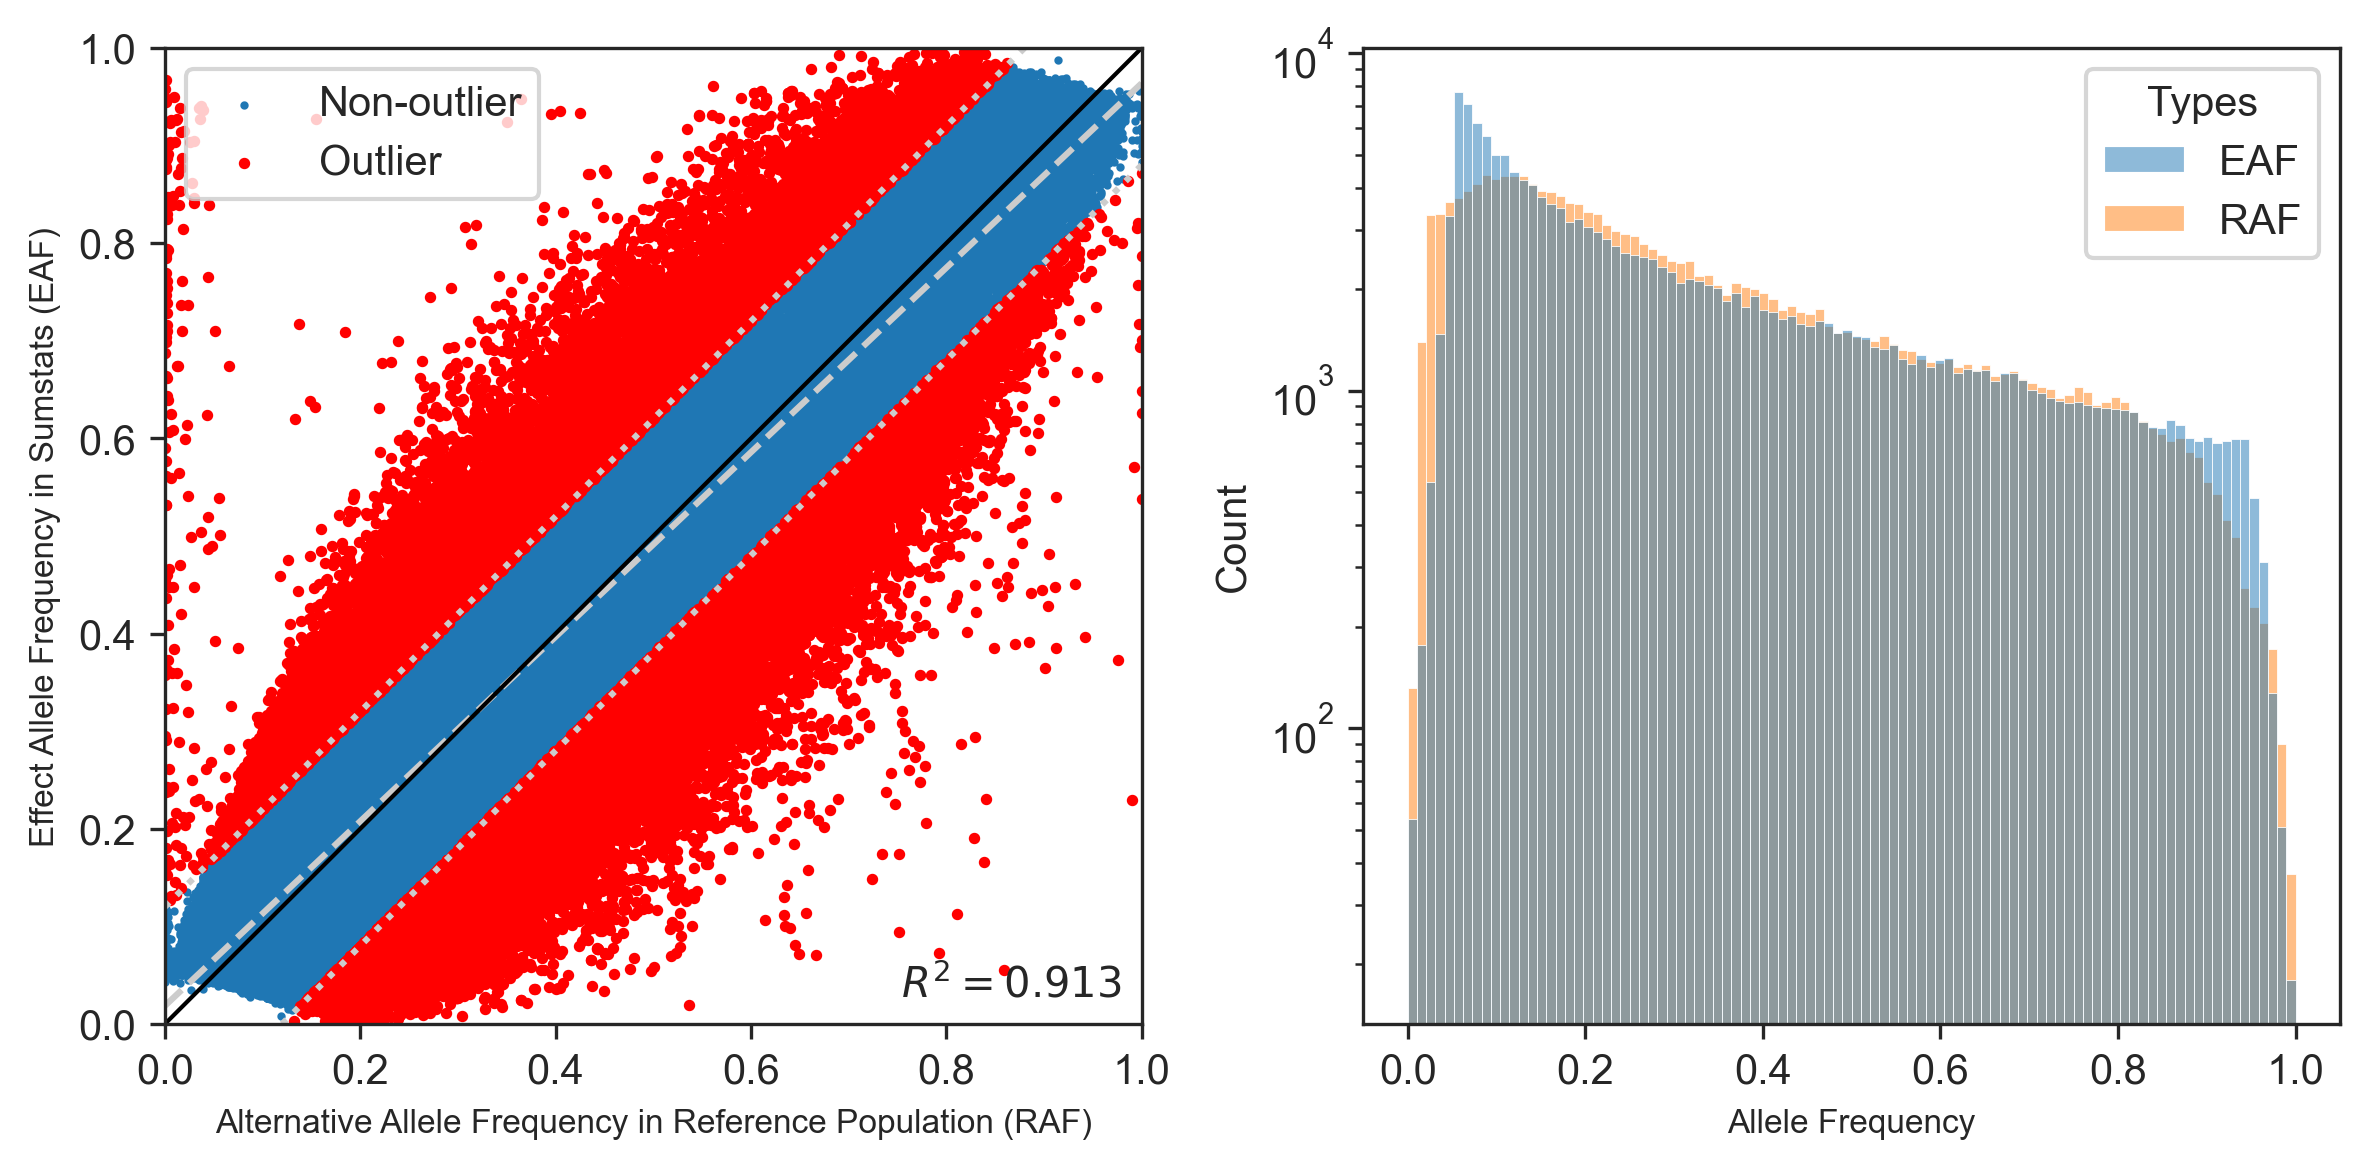

In [287]:
gwas_combo_sumstats_sample.plot_daf(threshold=0.12)

In [288]:
gwas_women_sumstats_sample.check_af(
    ref_infer=gl.get_path("1kg_eur_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Fri Sep 15 21:15:04 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Fri Sep 15 21:15:04 2023  -Current Dataframe shape : 200000  x  14
Fri Sep 15 21:15:04 2023  -Reference vcf file: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 21:15:04 2023  -CPU Cores to use : 8
Fri Sep 15 21:15:04 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 21:15:04 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 21:15:04 2023  -Alternative allele frequency in INFO: AF
Fri Sep 15 21:15:05 2023  -Checking variants: 200000
Fri Sep 15 21:15:46 2023  - DAF min: 0.9512490034103394
Fri Sep 15 21:15:46 2023  - DAF max: -0.9230250120162964
Fri Sep 15 21:15:46 2023  - DAF sd: 0.03416580536765157
Fri Sep 15 21:15:46 2023  - abs(DAF) min: 0.0
Fri Sep 15 21:15:46 2023  - abs(DAF) max: 0.9512490034103394
Fri Sep 15 21:15:46 2023  - abs(DAF) sd: 0.030349649153610988
Fri Sep 15 21:15:46 2023 Finished allele frequency checking!


Fri Sep 15 21:15:46 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Fri Sep 15 21:15:47 2023  -Plotting valriants:176646
Fri Sep 15 21:15:47 2023  -Plotting regression line...
Fri Sep 15 21:15:47 2023  -Beta =  0.9875569158581229
Fri Sep 15 21:15:47 2023  -Intercept =  0.002025415840681888
Fri Sep 15 21:15:47 2023  -R2 =  0.9907007459194032
Fri Sep 15 21:15:47 2023  -Threshold : 0.12
Fri Sep 15 21:15:47 2023  -Variants with relatively large DAF :  1470
Fri Sep 15 21:15:47 2023  -Percentage for variants with relatively large DAF :  0.008321728202167046
Fri Sep 15 21:15:48 2023  -Skip saving figures!


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF                EA NEA       RAF
 2309153  5:112807459  0.469305 -0.225526  CCAGAGGTGGAGCCTA   C  0.694831
 542697     2:9893776  0.488351 -0.231331                 A   C  0.719682
 1735565   4:70253673  0.158111 -0.124195                 T   G  0.282306
 6073427   18:6759259  0.573806 -0.170727                 A   G  0.744533
 3861013   9:86652954  0.456658  0.120674                 G   C  0.335984
 ...              ...       ...       ...               ...  ..       ...
 1687166   4:53198866  0.774435  0.774435             AAAAT   A  0.000000
 3847708   9:81454447  0.657143  0.655155              ACAG   A  0.001988
 4571335  11:95256733  0.287032 -0.154320                 C   A  0.441352
 426040   1:216693171  0.215674 -0.219714                 A   G  0.435388
 5550585  15:55309506  0.113038 -0.396902                 T   G  0.509940
 
 [1470 rows x 6 columns])

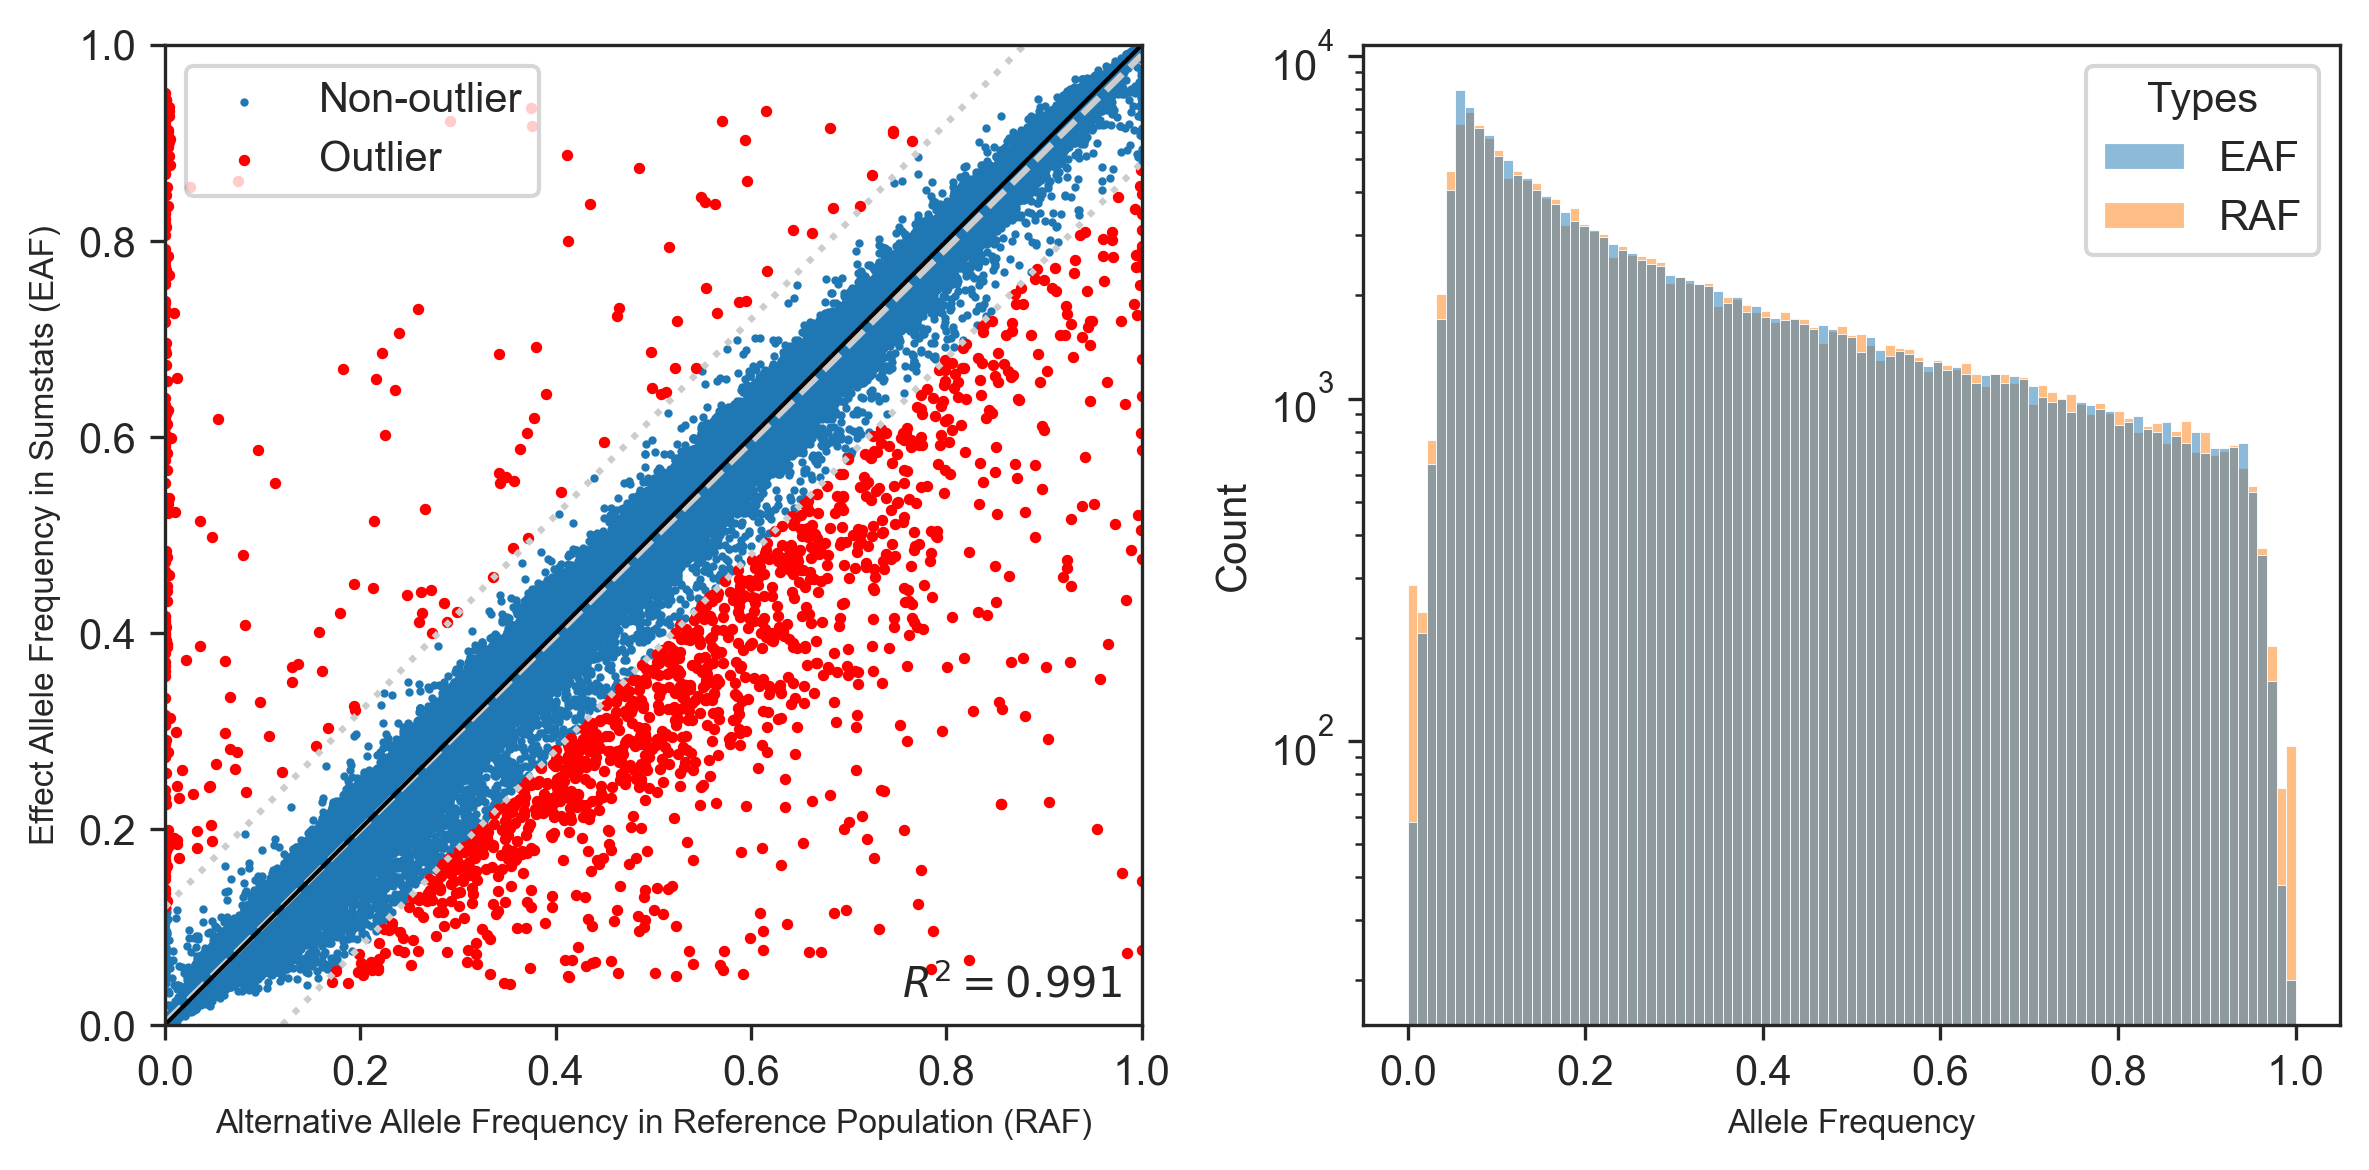

In [289]:
gwas_women_sumstats_sample.plot_daf(threshold=0.12)

In [290]:
gwas_men_sumstats_sample.check_af(
    ref_infer=gl.get_path("1kg_afr_hg19"),
    ref_alt_freq="AF",
    n_cores=8,
)

Fri Sep 15 21:15:56 2023 Start to check the difference between EAF and refence vcf alt frequency ...
Fri Sep 15 21:15:56 2023  -Current Dataframe shape : 200000  x  14
Fri Sep 15 21:15:56 2023  -Reference vcf file: /Users/slaan3/.gwaslab/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
Fri Sep 15 21:15:56 2023  -CPU Cores to use : 8
Fri Sep 15 21:15:56 2023  -Checking prefix for chromosomes in vcf files...
Fri Sep 15 21:15:56 2023  -No prefix for chromosomes in the VCF files.
Fri Sep 15 21:15:56 2023  -Alternative allele frequency in INFO: AF
Fri Sep 15 21:15:57 2023  -Checking variants: 200000
Fri Sep 15 21:16:49 2023  - DAF min: 0.985848558600992
Fri Sep 15 21:16:49 2023  - DAF max: -0.8900949954986572
Fri Sep 15 21:16:49 2023  - DAF sd: 0.217868244520489
Fri Sep 15 21:16:49 2023  - abs(DAF) min: 1.6205012798309326e-06
Fri Sep 15 21:16:49 2023  - abs(DAF) max: 0.985848558600992
Fri Sep 15 21:16:49 2023  - abs(DAF) sd: 0.1391036705762899
Fri Sep 15 21:16:49 2023 Finished allele frequency che

Fri Sep 15 21:16:49 2023 Start to plot Reference frequency vs Effect allele frequency plot...
Fri Sep 15 21:16:50 2023  -Plotting valriants:176542
Fri Sep 15 21:16:50 2023  -Plotting regression line...
Fri Sep 15 21:16:50 2023  -Beta =  0.6002983954671313
Fri Sep 15 21:16:50 2023  -Intercept =  0.13579755725430645
Fri Sep 15 21:16:50 2023  -R2 =  0.6578415040337544
Fri Sep 15 21:16:50 2023  -Threshold : 0.12
Fri Sep 15 21:16:50 2023  -Variants with relatively large DAF :  92750
Fri Sep 15 21:16:50 2023  -Percentage for variants with relatively large DAF :  0.5253707333099206
Fri Sep 15 21:16:52 2023  -Skip saving figures!


/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/gwaslab/compare_af.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


(<Figure size 2400x1200 with 2 Axes>,
                SNPID       EAF       DAF EA NEA       RAF
 6236220  18:75206918  0.934759  0.150341  G   A  0.784418
 927546   2:181296832  0.137530 -0.249762  A   G  0.387292
 6462521  20:19297706  0.352887  0.140330  T   A  0.212557
 6740647  22:48959266  0.636019  0.511965  C   T  0.124054
 167712    1:77011476  0.176556 -0.172158  A   G  0.348714
 ...              ...       ...       ... ..  ..       ...
 4534279  11:80531860  0.480250 -0.249705  T   C  0.729955
 5431663  14:93093252  0.650350  0.143542  A   C  0.506808
 1626673   4:27335723  0.635676  0.379246  A   T  0.256430
 2829330  6:130990354  0.457914 -0.328773  A   G  0.786687
 6630433  21:40492859  0.538303 -0.168959  A   G  0.707262
 
 [92750 rows x 6 columns])

/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/slaan3/miniconda3/envs/gwaslab/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


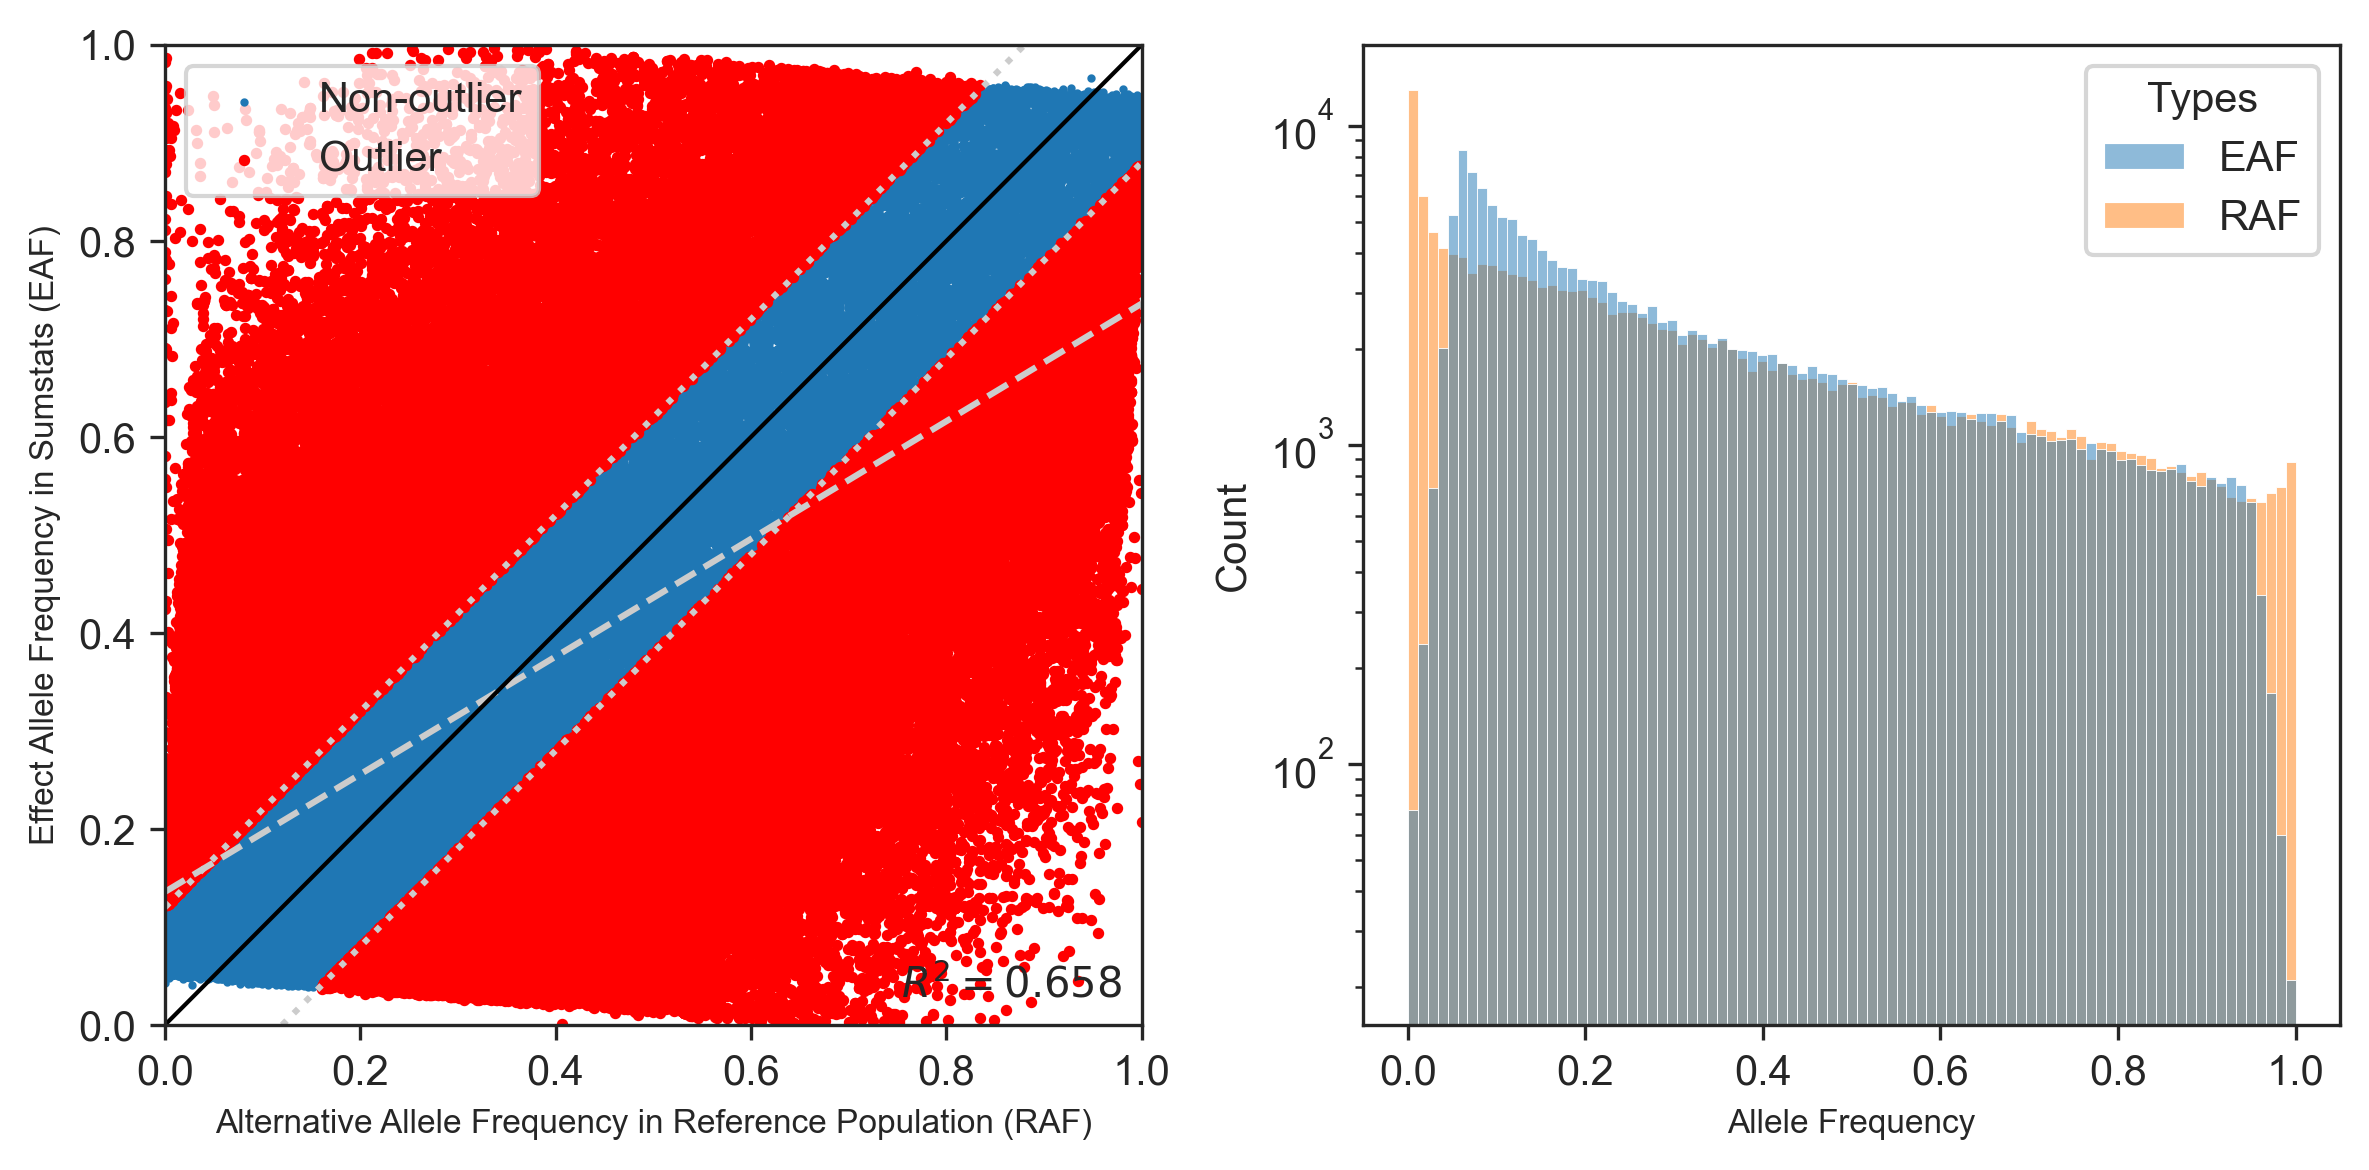

In [291]:
gwas_men_sumstats_sample.plot_daf(threshold=0.12)

In [292]:
del gwas_combo_sumstats_sample
del gwas_women_sumstats_sample
del gwas_men_sumstats_sample

##### Summary

So in summary we have done:
- a basic check, making sure the chr, pos, alleles are all in order
- multi-allelic, weird chromosomes, and duplicate variants are removed
- data are harmonized, such that the rsID is added, the alleles are relative to the references (and flipped if needed) 

In [293]:
print("The parsed and harmonized SumStats object for combined:\n")

gwas_combo_sumstats.data

The parsed and harmonized SumStats object for combined:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID
0,1:10583,1,10583,A,G,0.149751,0.658801,0.423637,0.12,0.301118,12145,1980019,rs58108140,<NA>
1,1:13302,1,13302,T,C,0.093359,0.139703,0.509556,0.78,0.332755,12145,1980019,rs180734498,<NA>
2,1:30923,1,30923,T,G,0.834095,-0.317905,0.403550,0.43,0.330267,12145,1980019,rs140337953,<NA>
3,1:51479,1,51479,A,T,0.180721,0.199339,0.383897,0.60,0.318227,12145,1980019,rs116400033,<NA>
4,1:54490,1,54490,A,G,0.176649,0.035508,0.383277,0.93,0.322577,12145,1980019,rs141149254,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.146274,0.027140,0.294785,0.93,0.641013,12145,1980019,rs144549712,<NA>
6750236,22:51233300,22,51233300,T,C,0.335996,-0.239342,0.212296,0.26,0.695615,12145,1980019,rs62240042,<NA>
6750237,22:51236013,22,51236013,A,AT,0.760900,-0.158471,0.241385,0.51,0.668405,12145,1980366,rs200507571,<NA>
6750238,22:51237063,22,51237063,C,T,0.276894,-0.277995,0.224458,0.22,0.696999,12145,1980019,rs3896457,<NA>


In [294]:
print("The parsed and harmonized SumStats object for European-only:\n")

gwas_women_sumstats.data

The parsed and harmonized SumStats object for European-only:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID
0,1:10583,1,10583,A,G,0.151617,0.824988,0.659326,0.21,0.301118,5344,1980019,rs58108140,<NA>
1,1:13302,1,13302,T,C,0.092958,0.659718,0.806601,0.41,0.332755,5344,1980019,rs180734498,<NA>
2,1:30923,1,30923,T,G,0.833661,-0.782017,0.644221,0.22,0.330267,5344,1980019,rs140337953,<NA>
3,1:51479,1,51479,A,T,0.183391,0.173976,0.602009,0.77,0.318227,5344,1980019,rs116400033,<NA>
4,1:54490,1,54490,A,G,0.179023,-0.308928,0.603387,0.61,0.322577,5344,1980019,rs141149254,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750233,22:51229855,22,51229855,A,G,0.148172,-0.390056,0.459037,0.40,0.641013,5344,1980019,rs144549712,<NA>
6750234,22:51233300,22,51233300,T,C,0.339706,-0.058844,0.336962,0.86,0.695615,5344,1980019,rs62240042,<NA>
6750235,22:51236013,22,51236013,A,AT,0.763283,-0.188759,0.383556,0.62,0.668405,5344,1980366,rs200507571,<NA>
6750236,22:51237063,22,51237063,C,T,0.278372,-0.374821,0.356019,0.29,0.696999,5344,1980019,rs3896457,<NA>


In [295]:
print("The parsed and harmonized SumStats object for African-American-only:\n")

gwas_men_sumstats.data

The parsed and harmonized SumStats object for African-American-only:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID
0,1:10583,1,10583,A,G,0.148284,0.519809,0.549089,0.34,0.301118,6801,1980019,rs58108140,<NA>
1,1:13302,1,13302,T,C,0.093675,-0.271376,0.651686,0.68,0.332755,6801,1980019,rs180734498,<NA>
2,1:30923,1,30923,T,G,0.834437,0.002467,0.513017,1.00,0.330267,6801,1980019,rs140337953,<NA>
3,1:51479,1,51479,A,T,0.178622,0.265338,0.494794,0.59,0.318227,6801,1980019,rs116400033,<NA>
4,1:54490,1,54490,A,G,0.174784,0.371793,0.492553,0.45,0.322577,6801,1980019,rs141149254,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750235,22:51229855,22,51229855,A,G,0.144783,0.274366,0.381691,0.47,0.641013,6801,1980019,rs144549712,<NA>
6750236,22:51233300,22,51233300,T,C,0.333080,-0.398509,0.270816,0.14,0.695615,6801,1980019,rs62240042,<NA>
6750237,22:51236013,22,51236013,A,AT,0.759029,-0.175344,0.307649,0.57,0.668405,6801,1980366,rs200507571,<NA>
6750238,22:51237063,22,51237063,C,T,0.275733,-0.245600,0.286446,0.39,0.696999,6801,1980019,rs3896457,<NA>


#### Save or open data
Let's save (or open) the summary statistics object for future reference.

In [296]:
import gwaslab as gl

gl.dump_pickle(
    gwas_combo_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_combo_sumstats = gl.load_pickle(
#     os.path.join(
#         GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.pkl"
#     )
# )

Fri Sep 15 22:50:19 2023 Start to dump the Sumstats Object.
Fri Sep 15 22:50:19 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_group/AOO_COMBINED_b37.gwaslab.pkl
Fri Sep 15 22:50:28 2023 Finished dumping.


In [297]:
import gwaslab as gl

gl.dump_pickle(
    gwas_women_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_women_sumstats = gl.load_pickle(
#     os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl")
# )

Fri Sep 15 22:50:28 2023 Start to dump the Sumstats Object.
Fri Sep 15 22:50:28 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_xx.group/AOO_WOMEN_b37.gwaslab.pkl
Fri Sep 15 22:50:36 2023 Finished dumping.


In [298]:
import gwaslab as gl

gl.dump_pickle(
    gwas_men_sumstats,
    os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.pkl"),
    overwrite=True,
)

# gwas_men_sumstats = gl.load_pickle(
#     os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.pkl")
# )

Fri Sep 15 22:50:36 2023 Start to dump the Sumstats Object.
Fri Sep 15 22:50:36 2023  -Dump the Sumstats Object to :  /Users/slaan3/PLINK/_GWAS_Datasets/_SiGN/discovery_xy.group/AOO_MEN_b37.gwaslab.pkl
Fri Sep 15 22:50:45 2023 Finished dumping.


In [299]:
import gwaslab as gl

gwas_combo_sumstats.log.show()

gwas_combo_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.log")
)

Fri Sep 15 17:13:12 2023 Sumstats Object created.
Fri Sep 15 17:13:12 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:12 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:12 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:17 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:17 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:17 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:19 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:13:22 2023 Start to reorder the columns...
Fri Sep 15 17:13:22 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:13:22 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:13:22 2023 Finished sorting columns successfully!
Fri Sep 15 17:13:22 2023  -Column:

In [300]:
import gwaslab as gl

gwas_women_sumstats.log.show()

gwas_women_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.log")
)

Fri Sep 15 17:13:32 2023 Sumstats Object created.
Fri Sep 15 17:13:32 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:32 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:32 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:38 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:38 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:38 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:41 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:13:44 2023 Start to reorder the columns...
Fri Sep 15 17:13:44 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:13:44 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:13:44 2023 Finished sorting columns successfully!
Fri Sep 15 17:13:45 2023  -Column:

In [301]:
import gwaslab as gl

gwas_men_sumstats.log.show()

gwas_men_sumstats.log.save(
    os.path.join(GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.log")
)

Fri Sep 15 17:13:45 2023 Sumstats Object created.
Fri Sep 15 17:13:45 2023 GWASLab v3.4.24 https://cloufield.github.io/gwaslab/
Fri Sep 15 17:13:45 2023 (C) 2022-2023, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
Fri Sep 15 17:13:45 2023 Start to initiate from pandas DataFrame ...
Fri Sep 15 17:13:50 2023  -Reading columns          : SE,P_BOLT_LMM_INF,A1FREQ,CHRBPID,BETA,CHR,N,BP,ALLELE0,INFO,ALLELE1,VariantID
Fri Sep 15 17:13:50 2023  -Renaming columns to      : SE,P,EAF,SNPID,BETA,CHR,N,POS,NEA,INFO,EA,VariantID
Fri Sep 15 17:13:50 2023  -Current Dataframe shape : 6750263  x  12
Fri Sep 15 17:13:52 2023  -Initiating a status column: STATUS ...
Fri Sep 15 17:29:12 2023 Start to reorder the columns...
Fri Sep 15 17:29:12 2023  -Current Dataframe shape : 6750263  x  13
Fri Sep 15 17:29:12 2023  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID
Fri Sep 15 17:29:13 2023 Finished sorting columns successfully!
Fri Sep 15 17:29:13 2023  -Column:

##### Parquet

Save it as a parquet for easy loading as a dataframe in other programs (_e.g._ `R`).

In [302]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_combo_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_group/AOO_COMBINED_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

In [303]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_women_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_xx.group/AOO_WOMEN_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

In [304]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(gwas_men_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWAS_RES_loc, "discovery_xy.group/AOO_MEN_b37.gwaslab.parquet"),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

##### GWAS Catalog

Save it in `GWAS catalog`-format

In [306]:
gwas_combo_sumstats.to_format(
    os.path.join(GWASCatalog_loc, "AOO_COMBINED_b37.gwaslab.ssf"),
    fmt="ssf",
    build="19",
)

Fri Sep 15 22:56:52 2023 Start to format the output sumstats in:  ssf  format
Fri Sep 15 22:56:54 2023  -Formatting statistics ...
Fri Sep 15 22:57:09 2023  - Float statistics formats:
Fri Sep 15 22:57:09 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P']
Fri Sep 15 22:57:09 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}']
Fri Sep 15 22:57:09 2023  - Replacing SNPID separator from ":" to "_"...
Fri Sep 15 22:57:11 2023  - Start outputting sumstats in ssf format...
Fri Sep 15 22:57:15 2023  -ssf format will be loaded...
Fri Sep 15 22:57:15 2023  -ssf format meta info:
Fri Sep 15 22:57:15 2023   - format_name  : ssf
Fri Sep 15 22:57:15 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Fri Sep 15 22:57:15 2023   - format_cite_name  : GWAS-SSF v0.1
Fri Sep 15 22:57:15 2023   - format_separator  : \t
Fri Sep 15 22:57:15 2023   - format_na  : #NA
Fri Sep 15 22:57:15 2023   - format_col_order  : chromosome,base_pair_locatio

In [307]:
gwas_women_sumstats.to_format(
    os.path.join(GWASCatalog_loc, "AOO_WOMEN_b37.gwaslab.ssf"),
    fmt="ssf",
    build="19",
)

Fri Sep 15 22:59:01 2023 Start to format the output sumstats in:  ssf  format
Fri Sep 15 22:59:04 2023  -Formatting statistics ...
Fri Sep 15 22:59:17 2023  - Float statistics formats:
Fri Sep 15 22:59:17 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P']
Fri Sep 15 22:59:17 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}']
Fri Sep 15 22:59:17 2023  - Replacing SNPID separator from ":" to "_"...
Fri Sep 15 22:59:20 2023  - Start outputting sumstats in ssf format...
Fri Sep 15 22:59:24 2023  -ssf format will be loaded...
Fri Sep 15 22:59:24 2023  -ssf format meta info:
Fri Sep 15 22:59:24 2023   - format_name  : ssf
Fri Sep 15 22:59:24 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Fri Sep 15 22:59:24 2023   - format_cite_name  : GWAS-SSF v0.1
Fri Sep 15 22:59:24 2023   - format_separator  : \t
Fri Sep 15 22:59:24 2023   - format_na  : #NA
Fri Sep 15 22:59:24 2023   - format_col_order  : chromosome,base_pair_locatio

In [308]:
gwas_men_sumstats.to_format(
    os.path.join(GWAS_RES_loc, "AOO_MEN_b37.gwaslab.ssf"),
    fmt="ssf",
    build="19",
)

Fri Sep 15 23:01:05 2023 Start to format the output sumstats in:  ssf  format
Fri Sep 15 23:01:07 2023  -Formatting statistics ...
Fri Sep 15 23:01:21 2023  - Float statistics formats:
Fri Sep 15 23:01:21 2023   - Columns: ['EAF', 'BETA', 'SE', 'INFO', 'P']
Fri Sep 15 23:01:21 2023   - Output formats: ['{:.4g}', '{:.4f}', '{:.4f}', '{:.4f}', '{:.4e}']
Fri Sep 15 23:01:21 2023  - Replacing SNPID separator from ":" to "_"...
Fri Sep 15 23:01:24 2023  - Start outputting sumstats in ssf format...
Fri Sep 15 23:01:27 2023  -ssf format will be loaded...
Fri Sep 15 23:01:27 2023  -ssf format meta info:
Fri Sep 15 23:01:27 2023   - format_name  : ssf
Fri Sep 15 23:01:27 2023   - format_source  : https://www.biorxiv.org/content/10.1101/2022.07.15.500230v1.full
Fri Sep 15 23:01:27 2023   - format_cite_name  : GWAS-SSF v0.1
Fri Sep 15 23:01:27 2023   - format_separator  : \t
Fri Sep 15 23:01:27 2023   - format_na  : #NA
Fri Sep 15 23:01:27 2023   - format_col_order  : chromosome,base_pair_locatio

After this, we need to validate results for `GWAS Catalog`. For this purpose we created an environment based on python 3.9 and used `gwas-sumstats-tools` (https://github.com/EBISPOT/gwas-sumstats-tools). We remove any remaining variant with alleles formatted such that is unacceptable for `GWAS Catalog`.

### Visualisations

Here we attempt to create a genome-wide plot annotating significant genes.

#### Manhattan and stratified QQ plots

Here we create an automatically annotated Manhattan plot. Annotation is based on hg19 (GRCh37), ensembl 87 (https://ftp.ensembl.org/pub/grch37/release-109/gtf/homo_sapiens/).



#### Combined

Fri Sep 15 23:09:37 2023 Start to plot manhattan/qq plot with the following basic settings:
Fri Sep 15 23:09:37 2023  -Genomic coordinates version: 19...
Fri Sep 15 23:09:37 2023  -Genome-wide significance level is set to 5e-08 ...
Fri Sep 15 23:09:37 2023  -Raw input contains 6750240 variants...
Fri Sep 15 23:09:37 2023  -Plot layout mode is : mqq
Fri Sep 15 23:09:39 2023 Finished loading specified columns from the sumstats.
Fri Sep 15 23:09:39 2023 Start conversion and sanity check:
Fri Sep 15 23:09:39 2023  -Removed 0 variants with nan in CHR or POS column ...
Fri Sep 15 23:09:41 2023  -Removed 0 varaints with CHR <=0...
Fri Sep 15 23:09:41 2023  -Removed 0 variants with nan in EAF column ...
Fri Sep 15 23:09:41 2023  -Removed 0 variants with nan in P column ...
Fri Sep 15 23:09:42 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:09:42 2023  -Sumstats P values are being converted to -log10(P)...
Fri Sep 15 23:09:42 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fca017c0040>)

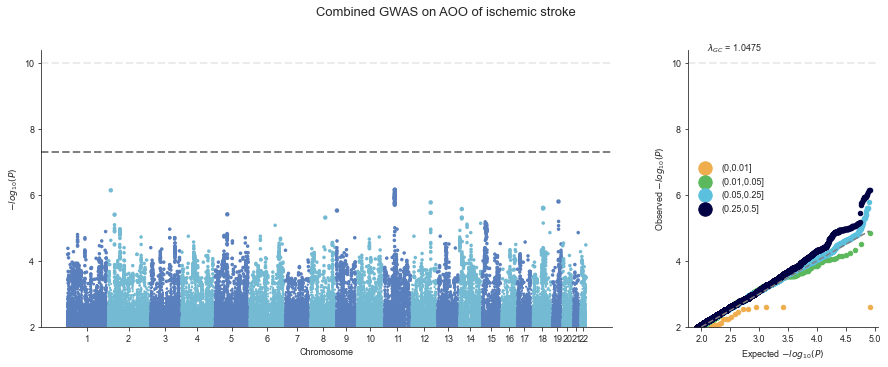

In [319]:
# manhattan and qq plot
gwas_combo_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Combined GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.COMBINED.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

Let's create publication ready images for the Nature Genetics revision.

Fri Sep 15 23:09:51 2023 Start to plot manhattan/qq plot with the following basic settings:
Fri Sep 15 23:09:51 2023  -Genomic coordinates version: 19...
Fri Sep 15 23:09:51 2023  -Genome-wide significance level is set to 5e-08 ...
Fri Sep 15 23:09:51 2023  -Raw input contains 6750240 variants...
Fri Sep 15 23:09:51 2023  -Plot layout mode is : qq
Fri Sep 15 23:09:52 2023 Finished loading specified columns from the sumstats.
Fri Sep 15 23:09:52 2023 Start conversion and sanity check:
Fri Sep 15 23:09:52 2023  -Removed 0 variants with nan in P column ...
Fri Sep 15 23:09:52 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:09:53 2023  -Sumstats P values are being converted to -log10(P)...
Fri Sep 15 23:09:53 2023  -Sanity check: 0 na/inf/-inf variants will be removed...
Fri Sep 15 23:09:54 2023  -Maximum -log10(P) values is 6.154901959985743 .
Fri Sep 15 23:09:54 2023 Finished data conversion and sanity check.
Fri Sep 15 23:0

(<Figure size 1080x360 with 1 Axes>, <gwaslab.Log.Log at 0x7fca017c0040>)

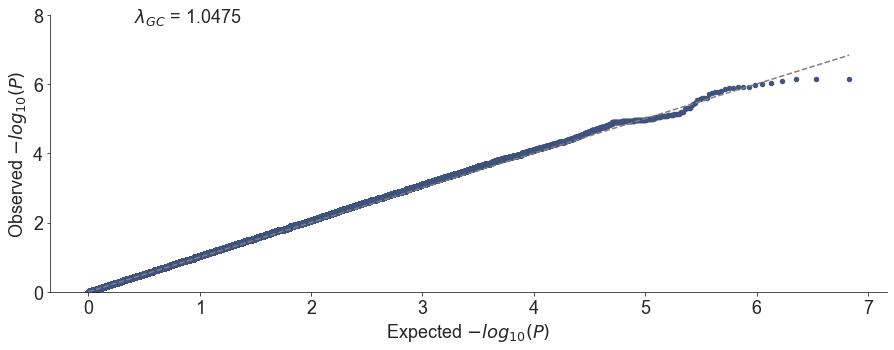

In [320]:
# qq plot
gwas_combo_sumstats.plot_mqq(
    build="19",
    mode="qq",  # only qq plot
    colors=["#3f517d", "#62acc2"],
    fontsize=18,
    # figargs={"figsize": (15, 15), "dpi": 300},
    save=os.path.join(PLOTS_loc, "qq_only.500kb.300dpi.COMBINED.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

#### Women-only populations

Fri Sep 15 23:10:33 2023 Start to plot manhattan/qq plot with the following basic settings:
Fri Sep 15 23:10:33 2023  -Genomic coordinates version: 19...
Fri Sep 15 23:10:33 2023  -Genome-wide significance level is set to 5e-08 ...
Fri Sep 15 23:10:33 2023  -Raw input contains 6750238 variants...
Fri Sep 15 23:10:33 2023  -Plot layout mode is : mqq
Fri Sep 15 23:10:34 2023 Finished loading specified columns from the sumstats.
Fri Sep 15 23:10:34 2023 Start conversion and sanity check:
Fri Sep 15 23:10:34 2023  -Removed 0 variants with nan in CHR or POS column ...
Fri Sep 15 23:10:36 2023  -Removed 0 varaints with CHR <=0...
Fri Sep 15 23:10:36 2023  -Removed 0 variants with nan in EAF column ...
Fri Sep 15 23:10:36 2023  -Removed 0 variants with nan in P column ...
Fri Sep 15 23:10:37 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:10:37 2023  -Sumstats P values are being converted to -log10(P)...
Fri Sep 15 23:10:38 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fca017c0040>)

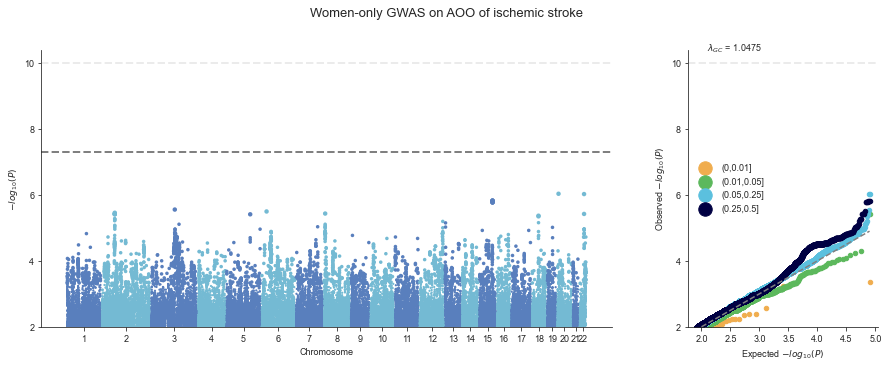

In [321]:
# manhattan and qq plot
gwas_women_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Women-only GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.WOMEN.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

#### Men-only populations

Fri Sep 15 23:10:46 2023 Start to plot manhattan/qq plot with the following basic settings:
Fri Sep 15 23:10:46 2023  -Genomic coordinates version: 19...
Fri Sep 15 23:10:46 2023  -Genome-wide significance level is set to 5e-08 ...
Fri Sep 15 23:10:46 2023  -Raw input contains 6750240 variants...
Fri Sep 15 23:10:46 2023  -Plot layout mode is : mqq
Fri Sep 15 23:10:47 2023 Finished loading specified columns from the sumstats.
Fri Sep 15 23:10:47 2023 Start conversion and sanity check:
Fri Sep 15 23:10:47 2023  -Removed 0 variants with nan in CHR or POS column ...
Fri Sep 15 23:10:49 2023  -Removed 0 varaints with CHR <=0...
Fri Sep 15 23:10:49 2023  -Removed 0 variants with nan in EAF column ...
Fri Sep 15 23:10:50 2023  -Removed 0 variants with nan in P column ...
Fri Sep 15 23:10:50 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:10:50 2023  -Sumstats P values are being converted to -log10(P)...
Fri Sep 15 23:10:51 2023 

(<Figure size 1080x360 with 2 Axes>, <gwaslab.Log.Log at 0x7fca017c0040>)

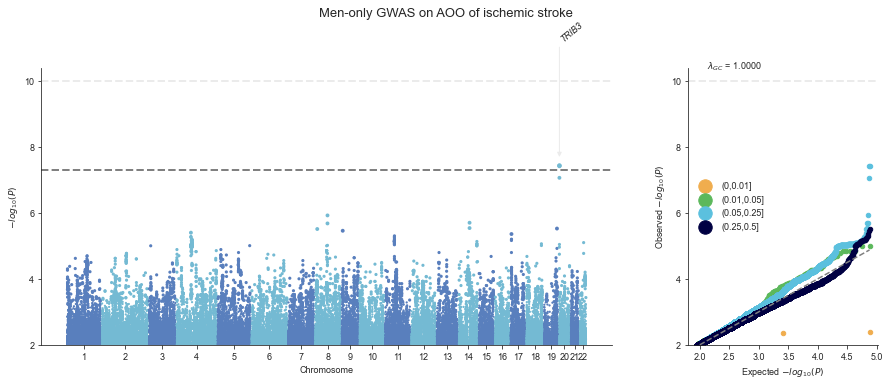

In [322]:
# manhattan and qq plot
gwas_men_sumstats.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="Men-only GWAS on AOO of ischemic stroke",
    save=os.path.join(PLOTS_loc, "manhattan.500kb.300dpi.MEN.pdf"),
    saveargs={"dpi": 300},
    verbose=True,
)

### Top loci

We inventory the top loci. 


In [315]:
gwas_combo_sumstats.get_lead(anno=True)

Fri Sep 15 23:06:12 2023 Start to extract lead variants...
Fri Sep 15 23:06:12 2023  -Processing 6750240 variants...
Fri Sep 15 23:06:12 2023  -Significance threshold : 5e-08
Fri Sep 15 23:06:12 2023  -Sliding window size: 500  kb
Fri Sep 15 23:06:16 2023  -Found 0 significant variants in total...
Fri Sep 15 23:06:16 2023  -Identified 0 lead variants!
Fri Sep 15 23:06:16 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID


In [316]:
gwas_women_sumstats.get_lead(anno=True)

Fri Sep 15 23:06:16 2023 Start to extract lead variants...
Fri Sep 15 23:06:16 2023  -Processing 6750238 variants...
Fri Sep 15 23:06:16 2023  -Significance threshold : 5e-08
Fri Sep 15 23:06:16 2023  -Sliding window size: 500  kb
Fri Sep 15 23:06:20 2023  -Found 0 significant variants in total...
Fri Sep 15 23:06:20 2023  -Identified 0 lead variants!
Fri Sep 15 23:06:20 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID


In [317]:
gwas_men_sumstats.get_lead(anno=True)

Fri Sep 15 23:06:21 2023 Start to extract lead variants...
Fri Sep 15 23:06:21 2023  -Processing 6750240 variants...
Fri Sep 15 23:06:21 2023  -Significance threshold : 5e-08
Fri Sep 15 23:06:21 2023  -Sliding window size: 500  kb
Fri Sep 15 23:06:26 2023  -Found 2 significant variants in total...
Fri Sep 15 23:06:26 2023  -Identified 1 lead variants!
Fri Sep 15 23:06:26 2023  -Annotating variants using references:ensembl
Fri Sep 15 23:06:26 2023  -Annotating variants using references based on genome build:19
Fri Sep 15 23:06:26 2023 Start to annotate variants with nearest gene name(s)...
Fri Sep 15 23:06:26 2023  -Assigning Gene name using ensembl_hg19_gtf for protein coding genes
Fri Sep 15 23:06:26 2023 Finished annotating variants with nearest gene name(s) successfully!
Fri Sep 15 23:06:26 2023 Finished extracting lead variants successfully!


,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,INFO,N,STATUS,VariantID,rsID,LOCATION,GENE
6408548,20:374763,20,374763,T,C,0.13519,-1.94908,0.354032,3.700000e-08,0.830396,6801,1980019,rs6051656,<NA>,0,TRIB3


Fri Sep 15 23:06:36 2023 Start to plot miami plot with the following basic settings:
Fri Sep 15 23:06:36 2023  -Genome-wide significance level is set to 5e-08 ...
Fri Sep 15 23:06:36 2023  -Sumstats1 CHR,POS,P information will be obtained from: ['CHR', 'POS', 'P']
Fri Sep 15 23:06:36 2023  -Loading sumstats1 from gwaslab.Sumstats Object
Fri Sep 15 23:06:36 2023  -Sumstats2 CHR,POS,P information will be obtained from: ['CHR', 'POS', 'P']
Fri Sep 15 23:06:36 2023  -Loading sumstats2 from gwaslab.Sumstats Object
Fri Sep 15 23:06:37 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:06:37 2023  -Sumstats P values are being converted to -log10(P)...
Fri Sep 15 23:06:37 2023  -Sanity check: 0 na/inf/-inf variants will be removed...
Fri Sep 15 23:06:38 2023  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Fri Sep 15 23:06:38 2023  -Sumstats P values are being converted to -log10(P)...
Fri 

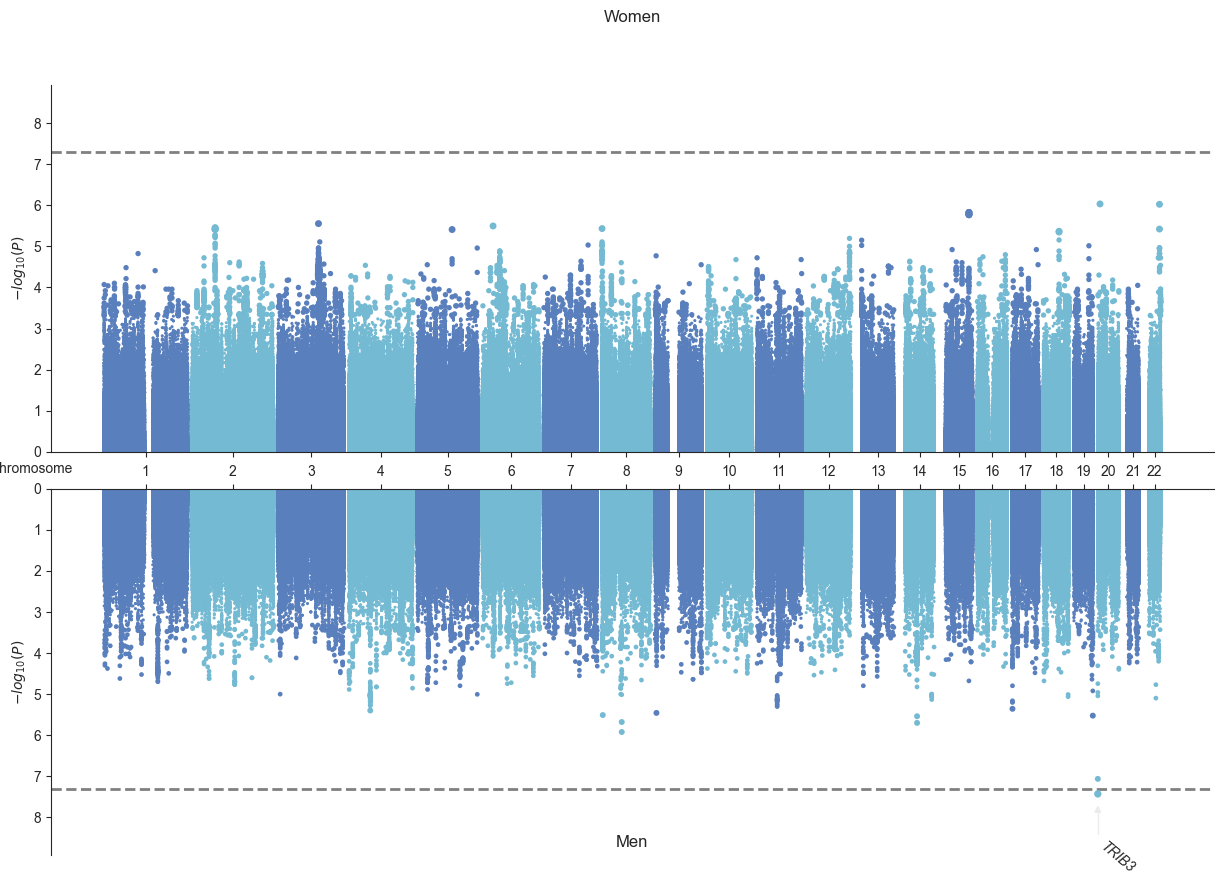

In [318]:
sumstats_miami = gl.plot_miami(
    path1=gwas_women_sumstats,
    path2=gwas_men_sumstats,
    cols1=["CHR", "POS", "P"],
    cols2=["CHR", "POS", "P"],
    titles=["Women", "Men"],
    titles_pad=[0.15, 0.0],
    anno="GENENAME",
    region_grid=True,
    highlight1=[(20, 374763)],  # TRIB3
    # pinpoint2=[(2,653874)]
)